## **Data Structure**:
```python
math_structure.from_text.domain          # Domain classification
math_structure.from_text.objects         # Problem objects
math_structure.from_text.constraints     # Problem constraints
math_structure.from_text.mechanisms      # Problem mechanisms
math_structure.from_solution.*           # Solution properties
computation_buckets[].level              # Difficulty buckets (minimum level with passed == 1)
```

## Setup & Load

In [35]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

In [36]:
# Load JSONL data
DATA_PATH = '/home/larcanio/AIMO3_v2/data/datasets/Dataset_Full/bucketed/dataset_full_metadata.jsonl'

records = []
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            try:
                records.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {e}")

print(f"Total records loaded: {len(records):,}")

Total records loaded: 71,832


## Extract Data Fields

In [37]:
# Extract relevant fields from math_structure
data = []
for record in records:
    row = {
        'id': record.get('id'),
        'dataset': record.get('dataset')
    }
    
    # Extract difficulty level from computation_buckets
    # The difficulty level is the minimum level where passes == 1
    if 'computation_buckets' in record and record['computation_buckets']:
        passed_levels = [bucket['level'] for bucket in record['computation_buckets'] 
                        if bucket.get('passes') == 1]
        if passed_levels:
            row['difficulty_level'] = min(passed_levels)

    # Extract outcome fields
    if 'outcome' in record and record['outcome']:
        row['pass_at_k'] = record['outcome'].get('pass_at_k')
    
    # Extract math_structure fields
    if 'math_structure' in record and record['math_structure']:
        ms = record['math_structure']
        
        # Extract from_text properties (including domain)
        if 'from_text' in ms and ms['from_text']:
            ft = ms['from_text']
            row['domain'] = ft.get('domain')  # Domain is in from_text.domain
            row['output_type'] = ft.get('output_type')
            row['mechanisms'] = ft.get('mechanisms', [])
            row['constraints'] = ft.get('constraints', [])
            row['objects'] = ft.get('objects', [])
            row['mechanisms_count'] = len(row['mechanisms']) if row['mechanisms'] else 0
            row['constraints_count'] = len(row['constraints']) if row['constraints'] else 0
            row['objects_count'] = len(row['objects']) if row['objects'] else 0
        
        # Extract from_solution properties
        if 'from_solution' in ms and ms['from_solution']:
            fs = ms['from_solution']
            row['reasoning_shape'] = fs.get('reasoning_shape')
            row['case_split'] = fs.get('case_split')
            row['invariant'] = fs.get('invariant')
            row['auxiliary_construction'] = fs.get('auxiliary_construction')
            row['reasoning_depth'] = fs.get('reasoning_depth')
            row['technique_transitions'] = fs.get('technique_transitions')
            row['argument_style'] = fs.get('argument_style')
            row['reasoning_scope'] = fs.get('reasoning_scope')
            row['dead_end_pruning'] = fs.get('dead_end_pruning')
            row['intermediate_reuse'] = fs.get('intermediate_reuse')
    
    data.append(row)

df = pd.DataFrame(data)
print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumns available: {list(df.columns)}")

# Summary of data extraction
print(f"\n" + "="*60)
print("Data Extraction Summary:")
print("="*60)
print(f"Total records: {len(df):,}")
for col in ['domain', 'difficulty_level', 'pass_at_k', 'reasoning_depth', 'case_split', 'reasoning_shape']:
    if col in df.columns:
        non_null = df[col].notna().sum()
        pct = (non_null / len(df) * 100) if len(df) > 0 else 0
        print(f"  {col:20s}: {non_null:6,} ({pct:5.1f}%)")
    else:
        print(f"  {col:20s}: Not found")




DataFrame shape: (71832, 22)

Columns available: ['id', 'dataset', 'difficulty_level', 'pass_at_k', 'domain', 'output_type', 'mechanisms', 'constraints', 'objects', 'mechanisms_count', 'constraints_count', 'objects_count', 'reasoning_shape', 'case_split', 'invariant', 'auxiliary_construction', 'reasoning_depth', 'technique_transitions', 'argument_style', 'reasoning_scope', 'dead_end_pruning', 'intermediate_reuse']

Data Extraction Summary:
Total records: 71,832
  domain              : 71,724 ( 99.8%)
  difficulty_level    : 55,804 ( 77.7%)
  pass_at_k           : 71,738 ( 99.9%)
  reasoning_depth     : 71,420 ( 99.4%)
  case_split          : 71,453 ( 99.5%)
  reasoning_shape     : 71,413 ( 99.4%)


## Attempt Distribution (pass_at_k)

In [38]:
# Attempt distribution table: how many samples solved in 1, 2, or 3 attempts
if 'pass_at_k' in df.columns and df['pass_at_k'].notna().any():
    df_pak = df[df['pass_at_k'].notna()].copy()
    total = len(df_pak)

    attempt_counts = df_pak['pass_at_k'].value_counts().sort_index()
    attempt_table = pd.DataFrame({
        'Attempts (pass_at_k)': attempt_counts.index.astype(int),
        'Count': attempt_counts.values,
        '%': (attempt_counts.values / total * 100).round(2),
    })
    attempt_table = attempt_table.reset_index(drop=True)

    print(f"Attempt Distribution (n={total:,})\n")
    print(attempt_table.to_string(index=False))
else:
    print("No pass_at_k data available")

Attempt Distribution (n=71,738)

 Attempts (pass_at_k)  Count     %
                    1  61229 85.35
                    2   7849 10.94
                    3   2257  3.15
                    4    377  0.53
                    5     21  0.03
                    6      5  0.01


In [39]:
print(json.dumps(records[0], indent=4))

{
    "id": "7a535244-361a-4c29-852d-0014dd1036c7",
    "dataset": "gsm8k",
    "problem_id": "0",
    "timestamp": "2026-02-06T20:39:18.551213",
    "problem": {
        "text": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?",
        "expected_answer": "72",
        "original_solution": "Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May."
    },
    "models": {
        "generating": "gpt-oss",
        "fixing": "gpt-oss"
    },
    "attempts": [
        {
            "n": 1,
            "stage": "initial",
            "model": "gpt-oss",
            "timestamp": "2026-02-06T20:39:18.551359",
            "code": "a = 48\nb = a // 2\ntotal = a + b\nprint(total)",
            "exec": {
                "status": "success",
                "stdout": "72",
                "stderr": null,
                "error": n

In [40]:
# Check which key columns are available
key_columns = ['domain', 'difficulty_level', 'mechanisms_count', 'constraints_count', 
               'objects_count', 'reasoning_depth', 'case_split', 'reasoning_shape',
               'auxiliary_construction', 'argument_style']
available_key_cols = [col for col in key_columns if col in df.columns]
print(f"\nKey columns found: {available_key_cols}")

if not available_key_cols:
    print("\nWARNING: No math_structure or computation_buckets data found in the dataset.")
    print("This notebook analyzes data from these fields. Please check your data source.")

# Check null percentages
print("\nNull percentage per key column:")
null_pct = (df[available_key_cols].isnull().sum() / len(df) * 100).sort_values(ascending=False)
for col, pct in null_pct.items():
    print(f"  {col}: {pct:.1f}%")


Key columns found: ['domain', 'difficulty_level', 'mechanisms_count', 'constraints_count', 'objects_count', 'reasoning_depth', 'case_split', 'reasoning_shape', 'auxiliary_construction', 'argument_style']

Null percentage per key column:
  difficulty_level: 22.3%
  argument_style: 2.8%
  reasoning_shape: 0.6%
  reasoning_depth: 0.6%
  case_split: 0.5%
  auxiliary_construction: 0.5%
  domain: 0.2%
  objects_count: 0.1%
  mechanisms_count: 0.1%
  constraints_count: 0.1%


## Difficulty Level Analysis


Records with difficulty level: 55,804 (77.7%)
Records without difficulty level: 16,028 (22.3%)

  Note: Difficulty level is extracted as the minimum level where passes == 1
        Records without difficulty have no computation_buckets with passes == 1

Difficulty Level Distribution (for records with difficulty):
difficulty_level
0.0      571
1.0     2152
2.0    10516
3.0     7295
4.0     2363
5.0     9772
6.0    14797
7.0     8338
Name: count, dtype: int64


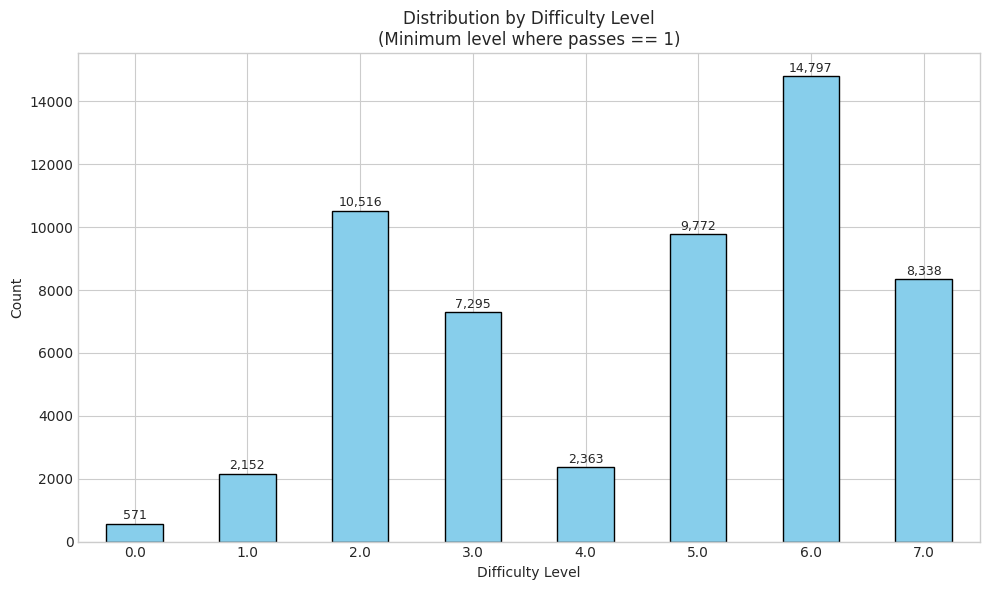

In [41]:
# Analyze difficulty level distribution
if 'difficulty_level' in df.columns and df['difficulty_level'].notna().any():
    df_with_diff = df[df['difficulty_level'].notna()].copy()
    df_without_diff = df[df['difficulty_level'].isna()].copy()
    
    print(f"\nRecords with difficulty level: {len(df_with_diff):,} ({len(df_with_diff)/len(df)*100:.1f}%)")
    print(f"Records without difficulty level: {len(df_without_diff):,} ({len(df_without_diff)/len(df)*100:.1f}%)")
    print(f"\n  Note: Difficulty level is extracted as the minimum level where passes == 1")
    print(f"        Records without difficulty have no computation_buckets with passes == 1")
    
    diff_counts = df_with_diff['difficulty_level'].value_counts().sort_index()
    print("\nDifficulty Level Distribution (for records with difficulty):")
    print(diff_counts)
    
    # Plot difficulty distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    diff_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel('Count')
    ax.set_title('Distribution by Difficulty Level\n(Minimum level where passes == 1)')
    plt.xticks(rotation=0)
    for i, v in enumerate(diff_counts.values):
        ax.text(i, v + max(diff_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo difficulty level data available")

## Level vs Computation Buckets
Each level in the computation ladder uses a specific **model**, **max_tokens**, and **execution_timeout**.  
Below we visualize how these resources scale across levels.

In [42]:
# ── Extract bucket configurations per level from raw data ──
from collections import defaultdict

level_configs = defaultdict(lambda: defaultdict(int))  # level -> (model, max_tokens, timeout) -> count

for rec in records:
    if not rec.get('computation_buckets'):
        continue
    for bucket in rec['computation_buckets']:
        lvl = bucket['level']
        model = bucket.get('model', '?')
        mt = bucket.get('max_tokens', None)
        et = bucket.get('execution_timeout', None)
        if mt is not None and et is not None:
            level_configs[lvl][(model, mt, et)] += 1

# Pick the most frequent config per level (handles minor data variations)
level_model, level_max_tokens, level_timeout = {}, {}, {}
for lvl in sorted(level_configs.keys()):
    most_common = max(level_configs[lvl].items(), key=lambda x: x[1])
    model, mt, et = most_common[0]
    level_model[lvl] = model
    level_max_tokens[lvl] = mt
    level_timeout[lvl] = et

bucket_df = pd.DataFrame({
    'level': sorted(level_model.keys()),
    'model': [level_model[l] for l in sorted(level_model.keys())],
    'max_tokens': [level_max_tokens[l] for l in sorted(level_max_tokens.keys())],
    'execution_timeout': [level_timeout[l] for l in sorted(level_timeout.keys())],
})

print("Computation Bucket Ladder:")
print(bucket_df.to_string(index=False))

Computation Bucket Ladder:
 level              model  max_tokens  execution_timeout
     0 qwen2.5-coder-0.5b          64                  1
     1 qwen2.5-coder-1.5b          64                  2
     2   qwen2.5-coder-3b         123                  2
     3   qwen2.5-coder-7b         256                  4
     4  qwen2.5-coder-14b         128                  8
     5    gpt-oss-20b-low         384                 20
     6    gpt-oss-20b-low        3072                 20
     7 gpt-oss-20b-medium        5120                 20


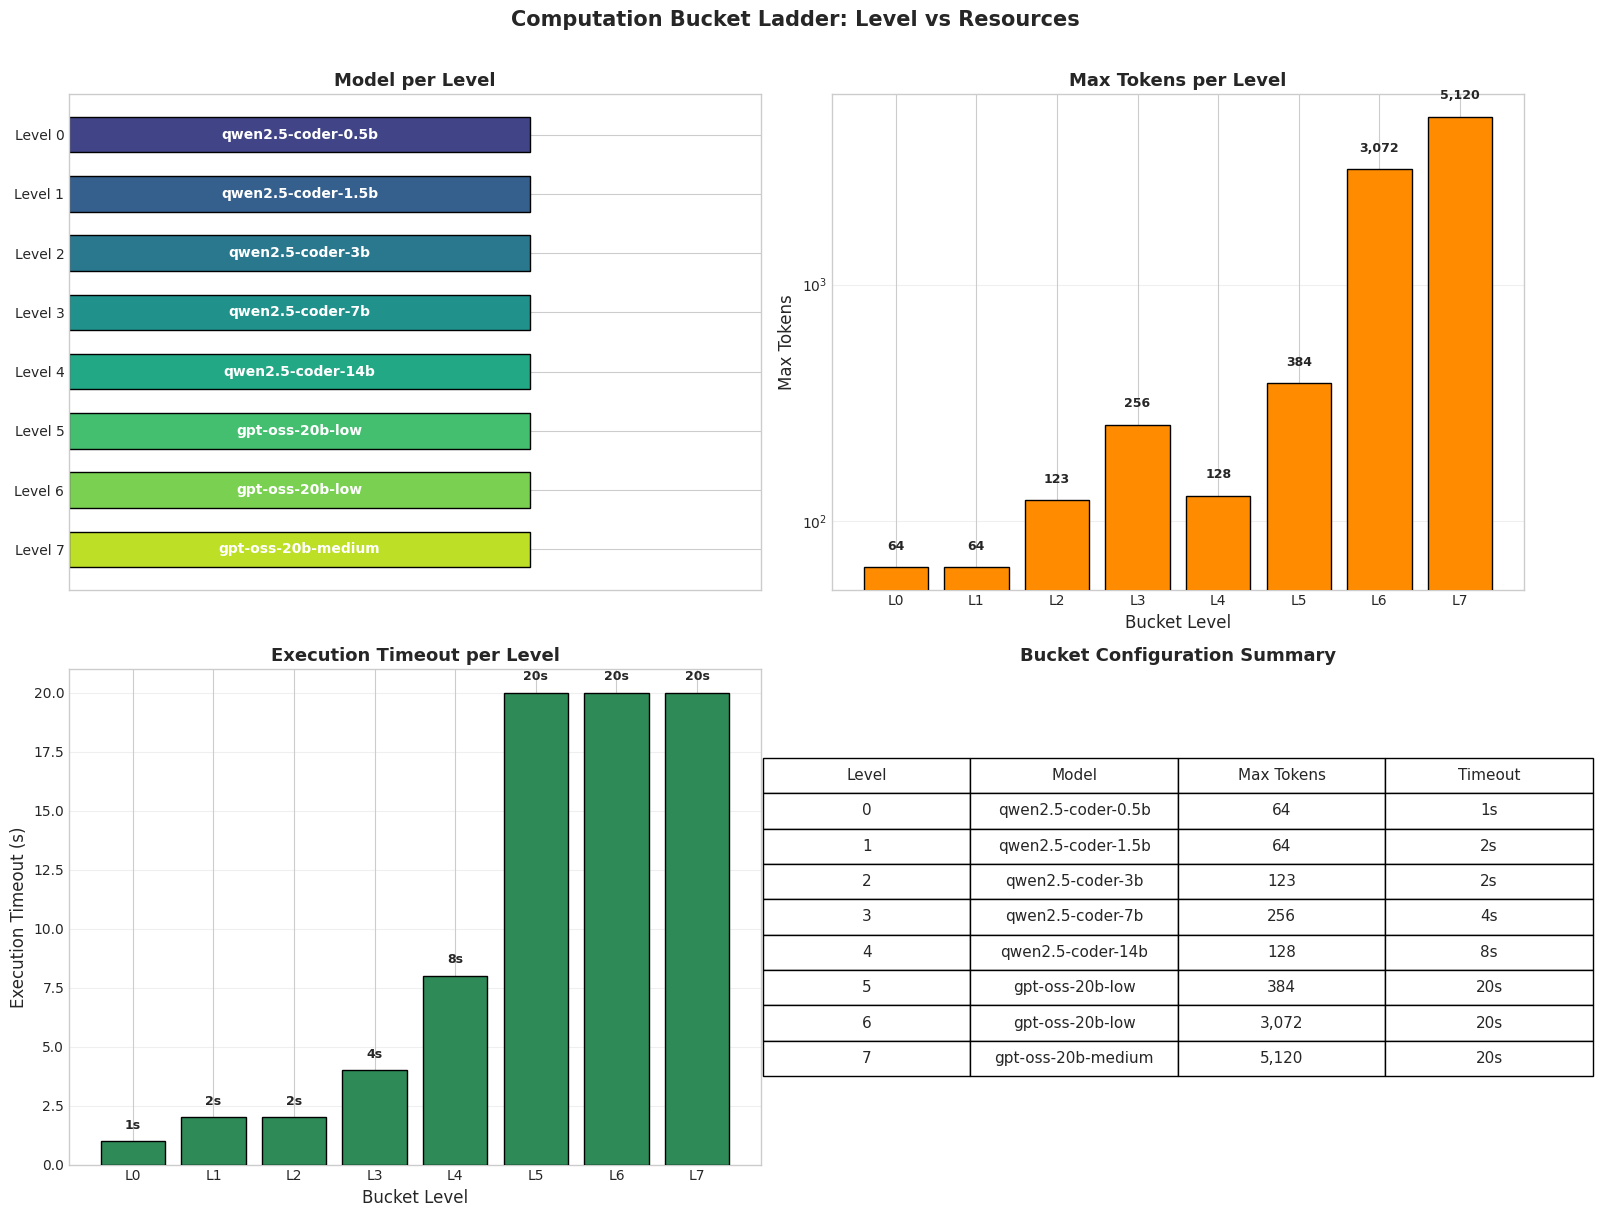

In [43]:
# ── 2x2 subplot: Model / Max Tokens / Execution Timeout per Level ──
levels = bucket_df['level'].values
models = bucket_df['model'].values
max_tokens = bucket_df['max_tokens'].values
exec_timeout = bucket_df['execution_timeout'].values

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ── Top-left: Model at each level (categorical ladder) ──
ax = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(levels)))
ax.barh(levels, [1]*len(levels), color=colors, edgecolor='black', height=0.6)
ax.set_yticks(levels)
ax.set_yticklabels([f'Level {l}' for l in levels])
ax.set_xlim(0, 1.5)
ax.set_xticks([])
ax.set_title('Model per Level', fontsize=13, fontweight='bold')
for lvl, m in zip(levels, models):
    ax.text(0.5, lvl, m, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
ax.invert_yaxis()

# ── Top-right: Max Tokens per level ──
ax = axes[0, 1]
bars = ax.bar(levels, max_tokens, color='darkorange', edgecolor='black', zorder=3)
ax.set_xlabel('Bucket Level', fontsize=12)
ax.set_ylabel('Max Tokens', fontsize=12)
ax.set_title('Max Tokens per Level', fontsize=13, fontweight='bold')
ax.set_xticks(levels)
ax.set_xticklabels([f'L{l}' for l in levels])
ax.set_yscale('log')
for bar, v in zip(bars, max_tokens):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.15,
            f'{v:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# ── Bottom-left: Execution Timeout per level ──
ax = axes[1, 0]
bars = ax.bar(levels, exec_timeout, color='seagreen', edgecolor='black', zorder=3)
ax.set_xlabel('Bucket Level', fontsize=12)
ax.set_ylabel('Execution Timeout (s)', fontsize=12)
ax.set_title('Execution Timeout per Level', fontsize=13, fontweight='bold')
ax.set_xticks(levels)
ax.set_xticklabels([f'L{l}' for l in levels])
for bar, v in zip(bars, exec_timeout):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(exec_timeout)*0.02,
            f'{v}s', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# ── Bottom-right: Summary table as text ──
ax = axes[1, 1]
ax.axis('off')
table_data = [[int(l), m, f'{t:,}', f'{e}s'] for l, m, t, e in zip(levels, models, max_tokens, exec_timeout)]
table = ax.table(cellText=table_data,
                 colLabels=['Level', 'Model', 'Max Tokens', 'Timeout'],
                 loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax.set_title('Bucket Configuration Summary', fontsize=13, fontweight='bold')

plt.suptitle('Computation Bucket Ladder: Level vs Resources', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## Difficulty Level vs Attempts (pass_at_k)

Records with both difficulty_level and pass_at_k: 55,754

pass_at_k distribution:
pass_at_k
1.0    49201
2.0     5085
3.0     1298
4.0      163
5.0        6
6.0        1
Name: count, dtype: int64

Difficulty Level vs pass_at_k (counts):
pass_at_k             1     2    3   4  5  6
Difficulty Level                            
0                   545    23    1   2  0  0
1                  2039    92   13   5  0  0
2                  9635   685  141  32  0  0
3                  6519   573  165  23  0  0
4                  2167   144   42   6  0  0
5                  8705   818  214  30  0  1
6                 12523  1784  451  35  3  0
7                  7068   966  271  30  3  0

Difficulty Level vs pass_at_k (% within level):
pass_at_k            1     2    3    4    5    6
difficulty_level                                
0                 95.4   4.0  0.2  0.4  0.0  0.0
1                 94.9   4.3  0.6  0.2  0.0  0.0
2                 91.8   6.5  1.3  0.3  0.0  0.0
3                 8

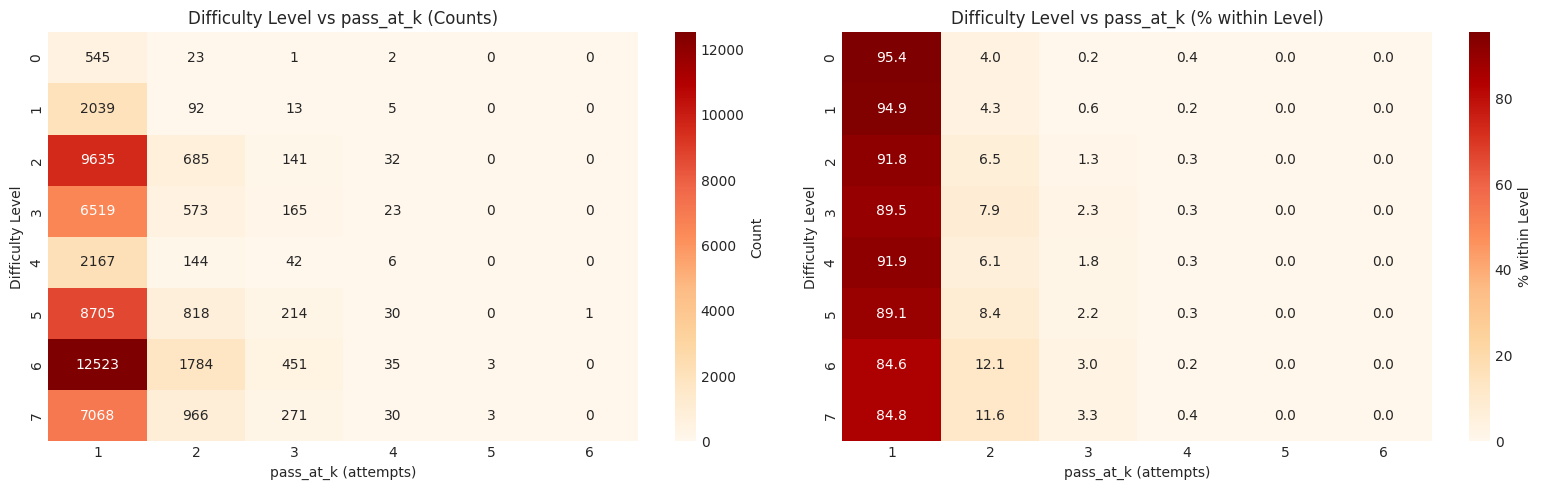

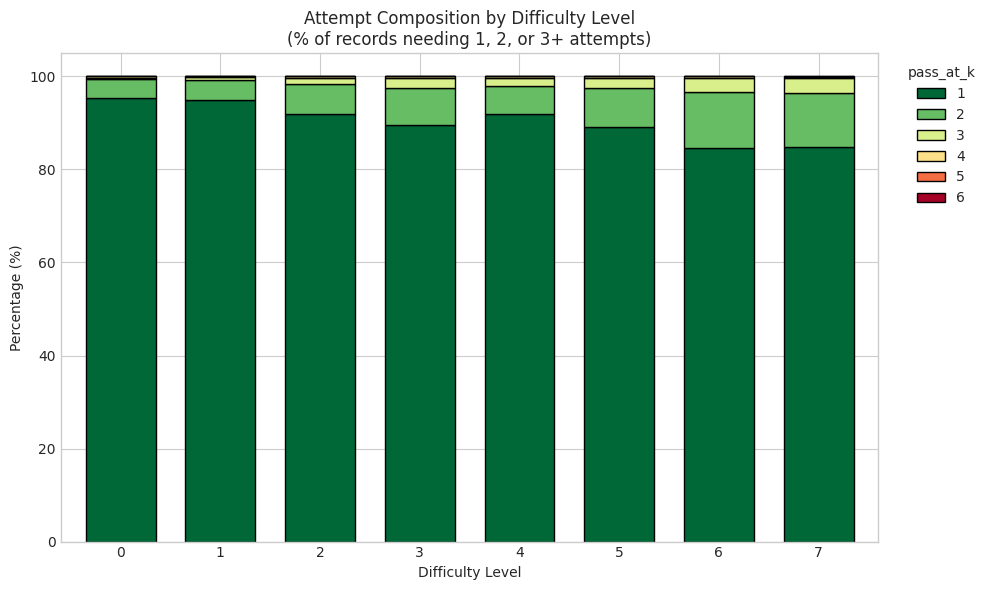

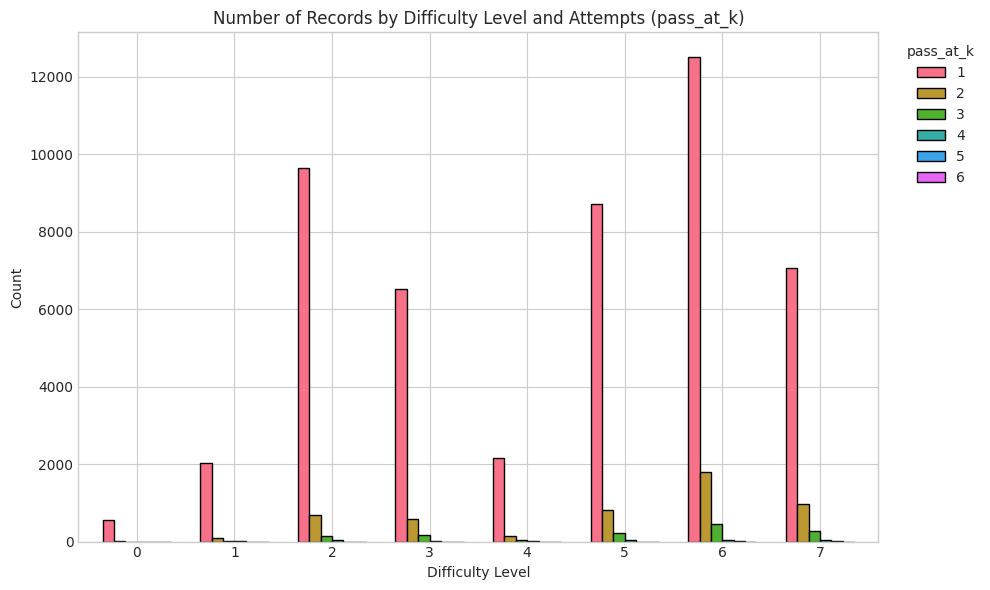


Average pass_at_k by Difficulty Level:
                   mean  median  count
difficulty_level                      
0                 1.054     1.0    571
1                 1.062     1.0   2149
2                 1.101     1.0  10493
3                 1.134     1.0   7280
4                 1.104     1.0   2359
5                 1.137     1.0   9768
6                 1.189     1.0  14796
7                 1.193     1.0   8338


In [44]:
# Difficulty Level vs pass_at_k (number of attempts to solve)
df_dk = df[df['difficulty_level'].notna() & df['pass_at_k'].notna()].copy()
print(f"Records with both difficulty_level and pass_at_k: {len(df_dk):,}")
print("\npass_at_k distribution:")
print(df_dk['pass_at_k'].value_counts().sort_index())

# Cross-tabulation
cross_dk = pd.crosstab(df_dk['difficulty_level'], df_dk['pass_at_k'])
cross_dk.index = cross_dk.index.astype(int)
cross_dk.columns = cross_dk.columns.astype(int)
cross_dk.index.name = 'Difficulty Level'
cross_dk.columns.name = 'pass_at_k'
print("\nDifficulty Level vs pass_at_k (counts):")
print(cross_dk)

# Normalized: % within each difficulty level
cross_dk_pct = pd.crosstab(df_dk['difficulty_level'], df_dk['pass_at_k'], normalize='index') * 100
cross_dk_pct.index = cross_dk_pct.index.astype(int)
cross_dk_pct.columns = cross_dk_pct.columns.astype(int)
print("\nDifficulty Level vs pass_at_k (% within level):")
print(cross_dk_pct.round(1))

# --- Plot 1: Heatmaps side by side ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(cross_dk, annot=True, fmt='d', cmap='OrRd', ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Difficulty Level vs pass_at_k (Counts)')
axes[0].set_xlabel('pass_at_k (attempts)')
axes[0].set_ylabel('Difficulty Level')

sns.heatmap(cross_dk_pct, annot=True, fmt='.1f', cmap='OrRd', ax=axes[1],
            cbar_kws={'label': '% within Level'})
axes[1].set_title('Difficulty Level vs pass_at_k (% within Level)')
axes[1].set_xlabel('pass_at_k (attempts)')
axes[1].set_ylabel('Difficulty Level')

plt.tight_layout()
plt.show()

# --- Plot 2: 100% stacked bar showing attempt composition per level ---
fig, ax = plt.subplots(figsize=(10, 6))
cross_dk_pct.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', width=0.7,
                  colormap='RdYlGn_r')
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Percentage (%)')
ax.set_title('Attempt Composition by Difficulty Level\n(% of records needing 1, 2, or 3+ attempts)')
ax.legend(title='pass_at_k', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylim(0, 105)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Plot 3: Grouped bar chart (raw counts) ---
fig, ax = plt.subplots(figsize=(10, 6))
cross_dk.plot(kind='bar', ax=ax, edgecolor='black', width=0.7)
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Count')
ax.set_title('Number of Records by Difficulty Level and Attempts (pass_at_k)')
ax.legend(title='pass_at_k', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Summary: average pass_at_k per level ---
avg_pak = df_dk.groupby('difficulty_level')['pass_at_k'].agg(['mean', 'median', 'count'])
avg_pak.index = avg_pak.index.astype(int)
print("\nAverage pass_at_k by Difficulty Level:")
print(avg_pak.round(3))

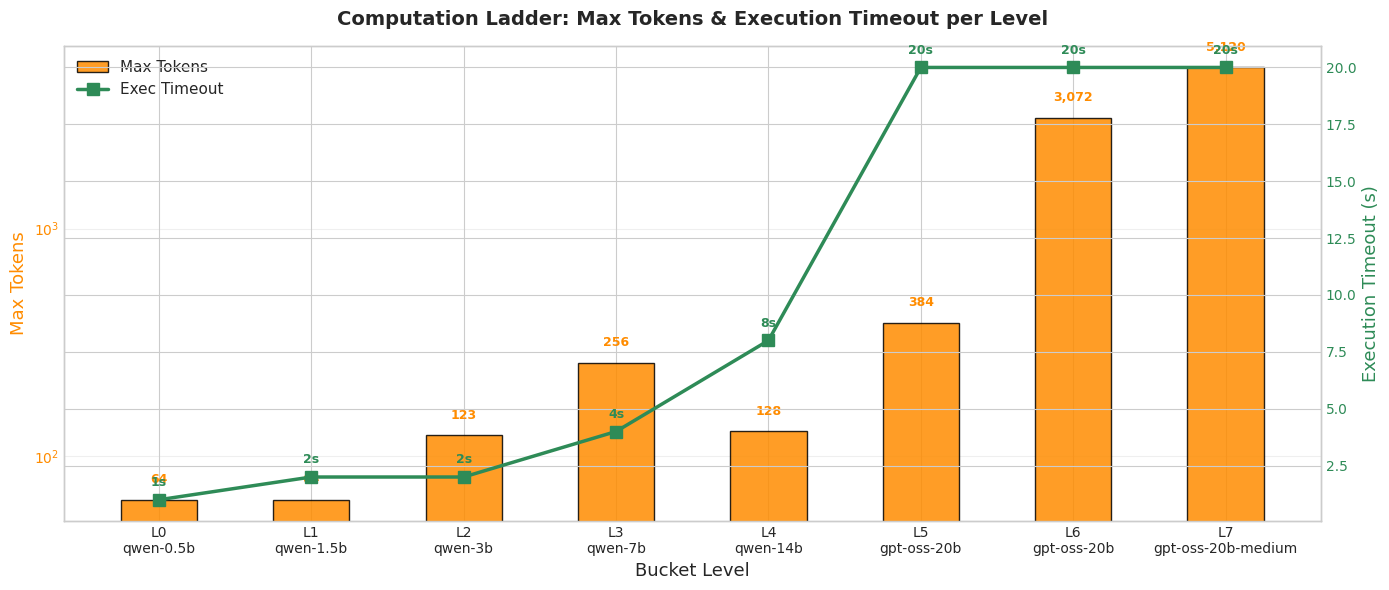

In [45]:
# ── Combined view: max_tokens + execution_timeout overlaid per level ──
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bars: max_tokens
bars = ax1.bar(levels, max_tokens, color='darkorange', edgecolor='black', width=0.5,
               zorder=3, alpha=0.85, label='Max Tokens')
ax1.set_xlabel('Bucket Level', fontsize=13)
ax1.set_ylabel('Max Tokens', fontsize=13, color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange')
ax1.set_yscale('log')
ax1.set_xticks(levels)

# Rich x-tick labels: Level + model name
xlabels = [f'L{l}\n{m.replace("qwen2.5-coder-", "qwen-").replace("gpt-oss-20b-low", "gpt-oss-20b")}'
           for l, m in zip(levels, models)]
ax1.set_xticklabels(xlabels, fontsize=10, ha='center')

for bar, v in zip(bars, max_tokens):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.15,
             f'{v:,}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkorange')

# Secondary y-axis: execution_timeout (line)
ax2 = ax1.twinx()
ax2.plot(levels, exec_timeout, 's-', color='seagreen', linewidth=2.5, markersize=9,
         label='Exec Timeout', zorder=4)
ax2.set_ylabel('Execution Timeout (s)', fontsize=13, color='seagreen')
ax2.tick_params(axis='y', labelcolor='seagreen')
for l, v in zip(levels, exec_timeout):
    ax2.annotate(f'{v}s', (l, v), textcoords='offset points', xytext=(0, 10),
                 ha='center', fontsize=9, fontweight='bold', color='seagreen')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, framealpha=0.9)

ax1.set_title('Computation Ladder: Max Tokens & Execution Timeout per Level',
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)
fig.tight_layout()
plt.show()

## Domain Distribution

In [46]:
# Filter to records with domain information
if 'domain' in df.columns:
    df_with_domain = df[df['domain'].notna()].copy()
    print(f"\nRecords with domain: {len(df_with_domain):,} ({len(df_with_domain)/len(df)*100:.1f}%)")
else:
    df_with_domain = pd.DataFrame()
    print("\nNo domain column found in dataset")


Records with domain: 71,724 (99.8%)



Domain Distribution:
domain
number_theory    20567
algebra          19174
geometry         16898
combinatorics    13591
mixed             1494
Name: count, dtype: int64


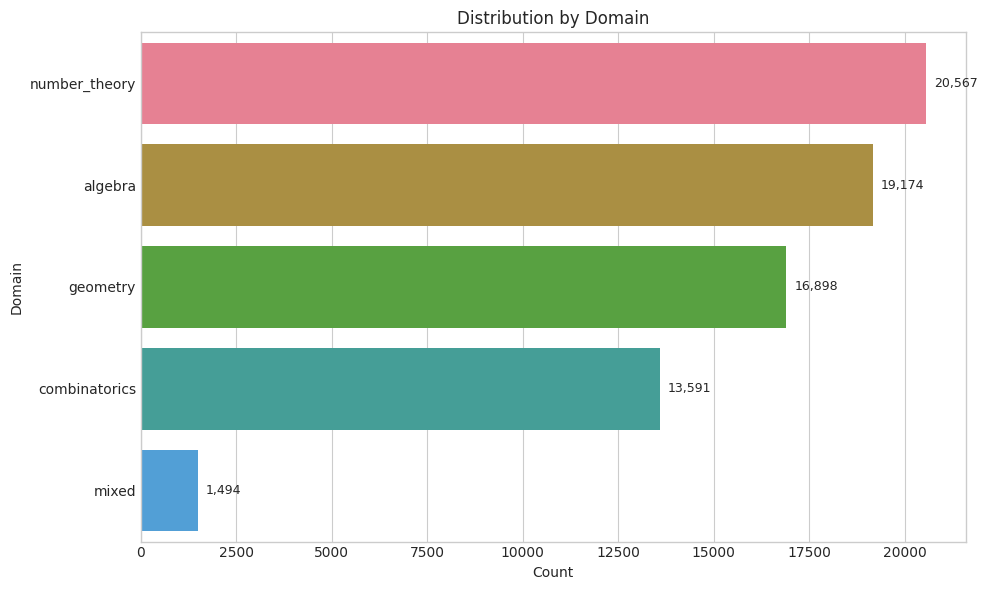

In [47]:
# Domain distribution
if len(df_with_domain) > 0:
    domain_counts = df_with_domain['domain'].value_counts()
    print("\nDomain Distribution:")
    print(domain_counts)
    
    # Plot domain distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=domain_counts.values, y=domain_counts.index, ax=ax, hue=domain_counts.index, legend=False)
    ax.set_xlabel('Count')
    ax.set_ylabel('Domain')
    ax.set_title('Distribution by Domain')
    for i, v in enumerate(domain_counts.values):
        ax.text(v + max(domain_counts.values)*0.01, i, f'{v:,}', va='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No domain data available for analysis")

## Survival / Retention Curve by Domain (Compute ↓)

**Conditional retention:** Of the problems a domain can solve at max compute, how many still pass as compute shrinks?

$$\text{Retention}_D(L) = \frac{\#\{\text{problems in } D \text{ with difficulty\_level} \leq L\}}{\#\{\text{problems in } D \text{ that pass at max level}\}}$$

- **Steep early drop** → domain collapses first under compute pressure
- **Flat curve** → compute-robust domain
- **Crossings** → regime changes (e.g. one domain overtakes another at low compute)

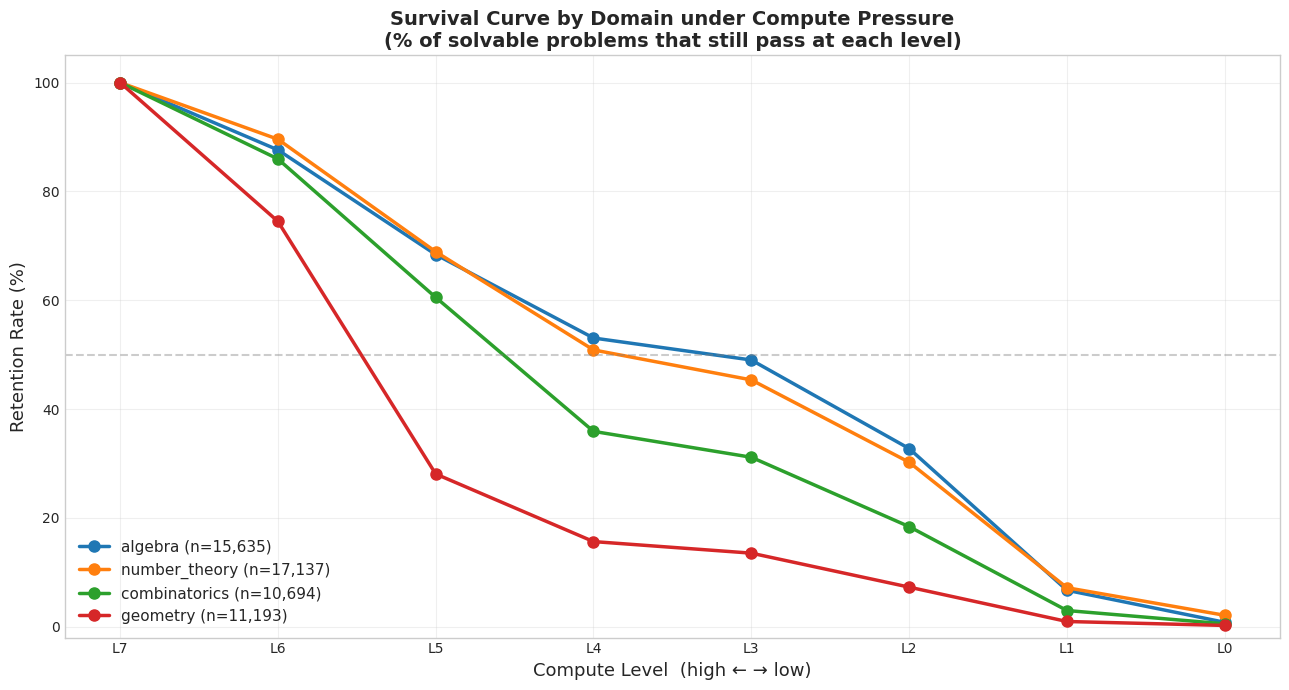


Retention Rate (%) by Domain and Level (high → low):
                  L7    L6    L5    L4    L3    L2   L1   L0
algebra        100.0  87.6  68.4  53.1  49.0  32.7  6.7  0.8
number_theory  100.0  89.6  68.9  50.9  45.4  30.2  7.2  2.1
combinatorics  100.0  86.0  60.5  35.9  31.1  18.4  3.0  0.5
geometry       100.0  74.5  28.1  15.6  13.5   7.3  1.0  0.2


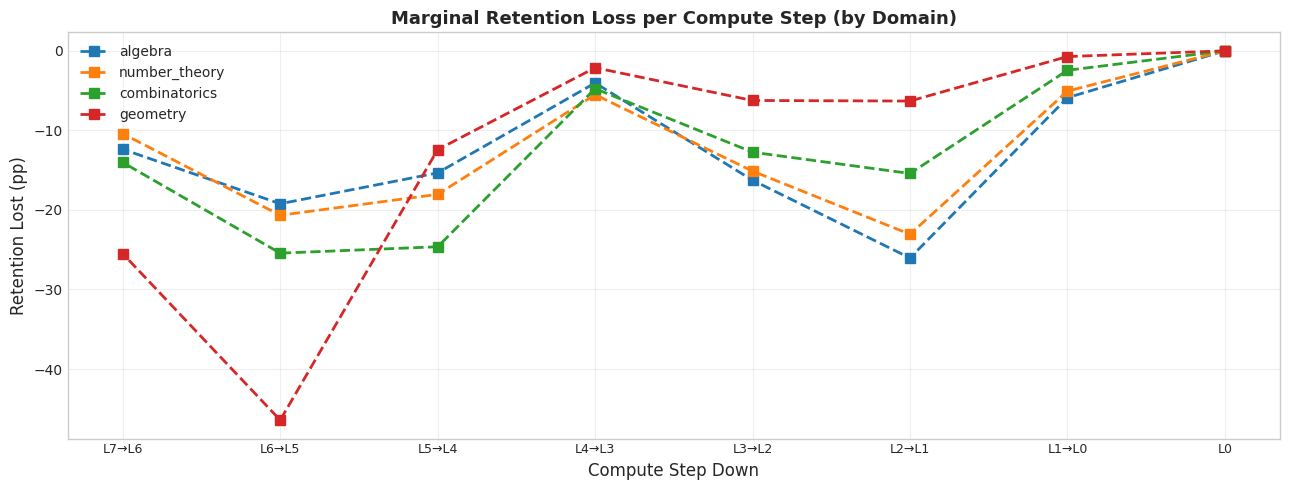

In [48]:
# ── Survival / Retention Curve by Domain (Compute ↓) ──
# Conditional retention (Option A):
#   Retention_D(L) = #{problems in D with difficulty_level <= L} / #{problems in D that have a difficulty_level}
# "Of the problems this domain can solve with enough compute, how many survive as compute shrinks?"

df_surv = df[df['difficulty_level'].notna() & df['domain'].notna()].copy()
df_surv['level'] = df_surv['difficulty_level'].astype(int)

domains = ['algebra', 'number_theory', 'combinatorics', 'geometry']
max_level = int(df_surv['level'].max())
levels_asc = list(range(0, max_level + 1))  # 0 .. 7

# Domain colors for consistency
domain_colors = {'algebra': '#1f77b4', 'number_theory': '#ff7f0e',
                 'combinatorics': '#2ca02c', 'geometry': '#d62728'}

# ── Main survival curve ──
fig, ax = plt.subplots(figsize=(13, 7))

for domain in domains:
    dom = df_surv[df_surv['domain'] == domain]
    total = len(dom)
    if total == 0:
        continue
    retention = [(dom['level'] <= L).sum() / total * 100 for L in levels_asc]
    ax.plot(levels_asc, retention, 'o-', label=f'{domain} (n={total:,})',
            linewidth=2.5, markersize=8, color=domain_colors.get(domain))

ax.set_xticks(levels_asc)
ax.set_xticklabels([f'L{l}' for l in levels_asc])
ax.invert_xaxis()  # high compute (L7) on left, low compute (L0) on right
ax.set_xlabel('Compute Level  (high ← → low)', fontsize=13)
ax.set_ylabel('Retention Rate (%)', fontsize=13)
ax.set_title('Survival Curve by Domain under Compute Pressure\n'
             '(% of solvable problems that still pass at each level)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, framealpha=0.9, loc='lower left')
ax.set_ylim(-2, 105)
ax.grid(True, alpha=0.3)
ax.axhline(y=50, color='grey', linestyle='--', alpha=0.4, label='_nolegend_')
plt.tight_layout()
plt.show()

# ── Retention table ──
print("\nRetention Rate (%) by Domain and Level (high → low):")
ret_data = {}
for domain in domains:
    dom = df_surv[df_surv['domain'] == domain]
    total = len(dom)
    if total == 0:
        continue
    ret_data[domain] = {f'L{L}': round((dom['level'] <= L).sum() / total * 100, 1)
                        for L in levels_asc}
ret_df = pd.DataFrame(ret_data).T
ret_df = ret_df[[f'L{l}' for l in reversed(levels_asc)]]  # high → low column order
print(ret_df)

# ── Delta chart: level-by-level drop ──
fig, ax = plt.subplots(figsize=(13, 5))
for domain in domains:
    dom = df_surv[df_surv['domain'] == domain]
    total = len(dom)
    if total == 0:
        continue
    retention = [(dom['level'] <= L).sum() / total * 100 for L in levels_asc]
    drops = [0] + [retention[i] - retention[i-1] for i in range(1, len(retention))]
    # drops are positive (gains going from low→high); we want loss going high→low
    loss = [-d for d in drops]  # loss at each step down
    ax.plot(levels_asc, loss, 's--', label=domain, linewidth=2, markersize=7,
            color=domain_colors.get(domain))

ax.set_xticks(levels_asc)
ax.set_xticklabels([f'L{l}→L{l-1}' if l > 0 else 'L0' for l in levels_asc], fontsize=9)
ax.invert_xaxis()
ax.set_xlabel('Compute Step Down', fontsize=12)
ax.set_ylabel('Retention Lost (pp)', fontsize=12)
ax.set_title('Marginal Retention Loss per Compute Step (by Domain)',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Domain-Conditioned Survival AUC (Area Under the Retention Curve)

$$\text{AUC}_D = \sum_{L=L_{\min}}^{L_{\max}} \text{Retention}_D(L)$$

**Interpretation:** Expected fraction of solvable instances that remain solvable under random compute truncation.

- **Lower AUC** → collapses early → higher effective difficulty under compute constraints
- **Higher AUC** → degrades gracefully → compute-robust domain

AUC is stable, holistic, and defensible: it integrates all levels (not just one threshold), captures early vs late collapse, and produces one scalar per domain.

Domain-Conditioned Survival AUC (normalized 0-1):
  algebra               AUC = 0.4979
  number_theory         AUC = 0.4927
  combinatorics         AUC = 0.4193
  geometry              AUC = 0.3002

  Higher AUC = more compute-robust (degrades gracefully)
  Lower  AUC = collapses earlier under compute pressure


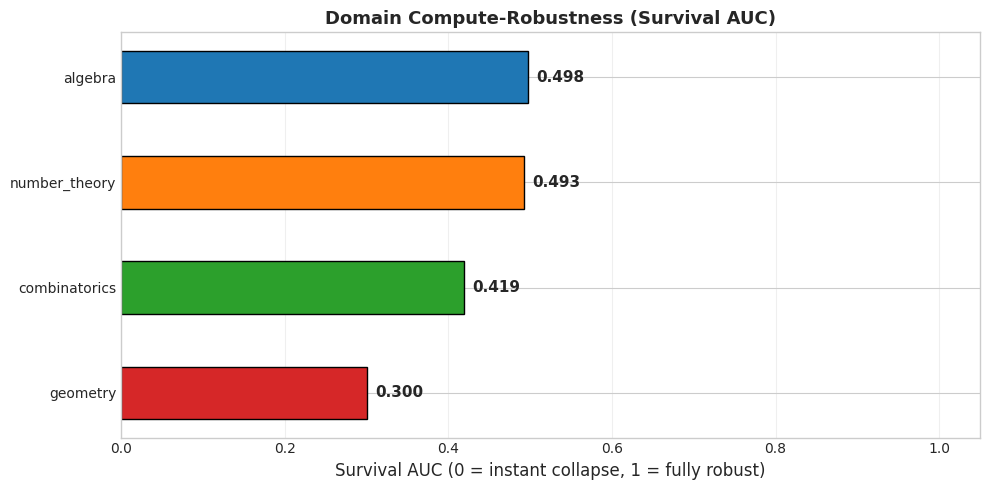

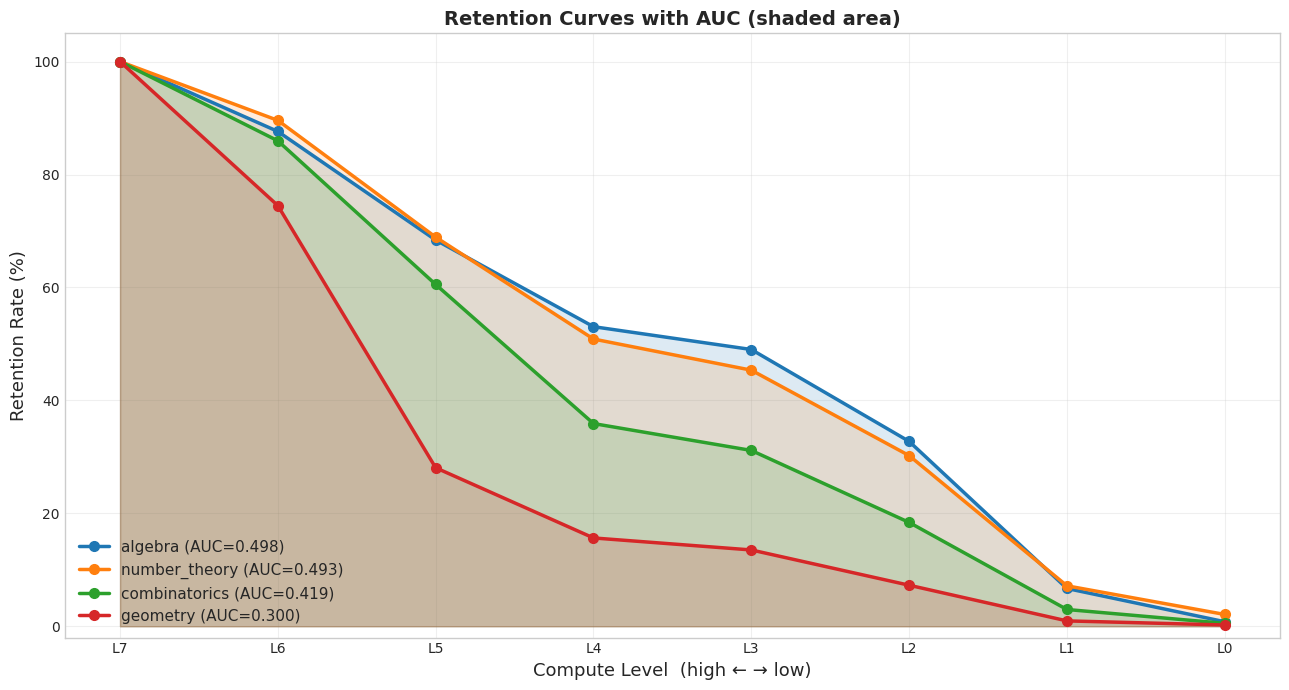


AUC Gap: algebra (0.4979) - geometry (0.3002) = 0.1977
  → algebra retains 19.8pp more solvability across the compute ladder than geometry


In [49]:
# ── Domain-Conditioned Survival AUC ──
# Reuse df_surv, domains, levels_asc, domain_colors from the survival curve cell above.
# AUC_D = sum of Retention_D(L) for L in [L_min .. L_max], normalized to [0, 1].
# Perfect retention at every level → AUC = 1.0; immediate collapse → AUC ≈ 0.

n_levels = len(levels_asc)  # number of discrete levels (8: 0..7)

auc_results = {}
retention_curves = {}
for domain in domains:
    dom = df_surv[df_surv['domain'] == domain]
    total = len(dom)
    if total == 0:
        continue
    retention = [(dom['level'] <= L).sum() / total for L in levels_asc]  # fraction, not %
    retention_curves[domain] = retention
    # Normalize: divide by n_levels so perfect = 1.0
    auc = sum(retention) / n_levels
    auc_results[domain] = auc

auc_series = pd.Series(auc_results).sort_values(ascending=False)

print("Domain-Conditioned Survival AUC (normalized 0-1):")
print("=" * 50)
for domain, auc in auc_series.items():
    print(f"  {domain:20s}  AUC = {auc:.4f}")
print(f"\n  Higher AUC = more compute-robust (degrades gracefully)")
print(f"  Lower  AUC = collapses earlier under compute pressure")

# ── Plot 1: AUC bar chart (ranked) ──
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(auc_series.index, auc_series.values,
               color=[domain_colors.get(d, 'grey') for d in auc_series.index],
               edgecolor='black', height=0.5)
ax.set_xlabel('Survival AUC (0 = instant collapse, 1 = fully robust)', fontsize=12)
ax.set_title('Domain Compute-Robustness (Survival AUC)', fontsize=13, fontweight='bold')
ax.set_xlim(0, 1.05)
for bar, v in zip(bars, auc_series.values):
    ax.text(v + 0.01, bar.get_y() + bar.get_height()/2, f'{v:.3f}',
            va='center', fontsize=11, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ── Plot 2: Filled retention curves showing AUC as shaded area ──
fig, ax = plt.subplots(figsize=(13, 7))
for domain in domains:
    if domain not in retention_curves:
        continue
    ret = [r * 100 for r in retention_curves[domain]]
    color = domain_colors.get(domain)
    ax.fill_between(levels_asc, ret, alpha=0.15, color=color)
    ax.plot(levels_asc, ret, 'o-', label=f'{domain} (AUC={auc_results[domain]:.3f})',
            linewidth=2.5, markersize=7, color=color)

ax.set_xticks(levels_asc)
ax.set_xticklabels([f'L{l}' for l in levels_asc])
ax.invert_xaxis()
ax.set_xlabel('Compute Level  (high ← → low)', fontsize=13)
ax.set_ylabel('Retention Rate (%)', fontsize=13)
ax.set_title('Retention Curves with AUC (shaded area)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower left')
ax.set_ylim(-2, 105)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ── AUC gap analysis ──
best = auc_series.idxmax()
worst = auc_series.idxmin()
gap = auc_series[best] - auc_series[worst]
print(f"\nAUC Gap: {best} ({auc_series[best]:.4f}) - {worst} ({auc_series[worst]:.4f}) = {gap:.4f}")
print(f"  → {best} retains {gap*100:.1f}pp more solvability across the compute ladder than {worst}")

## Domain vs Difficulty Level


Records with both domain and difficulty: 55,739

Domain vs Difficulty Level:
difficulty_level  0.0  1.0   2.0   3.0  4.0   5.0   6.0   7.0
domain                                                       
algebra           126  921  4072  2544  632  2399  3006  1935
combinatorics      56  262  1649  1363  509  2634  2720  1501
geometry           26   81   707   699  238  1391  5196  2855
mixed               3   18   127    80   35   245   324   248
number_theory     359  869  3952  2592  945  3092  3543  1785


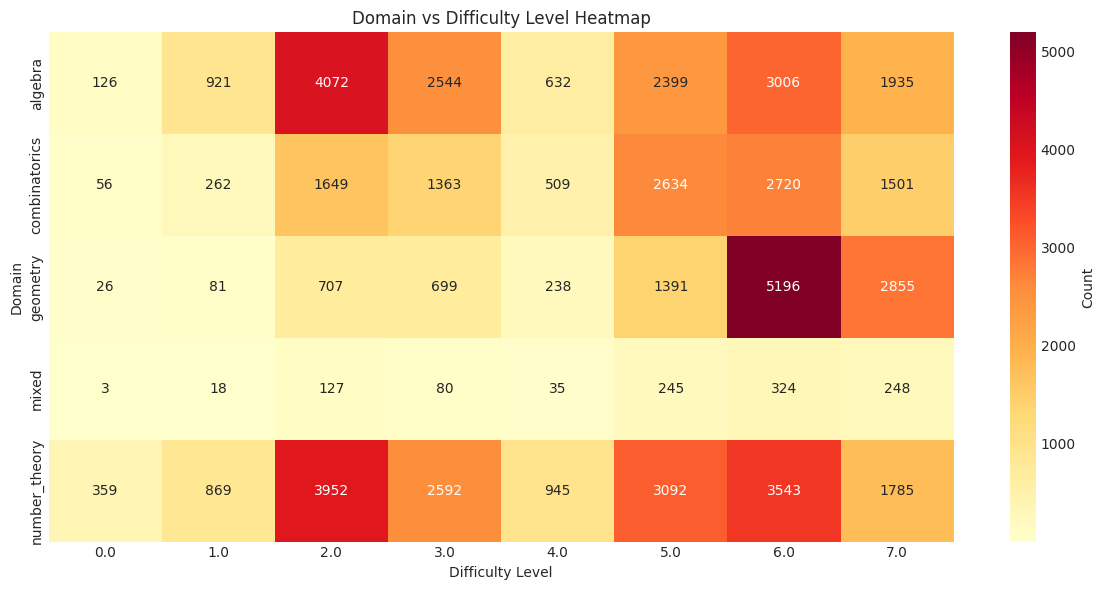


Average Difficulty by Domain:
                   mean  median  count
domain                                
geometry       5.598142     6.0  11193
mixed          5.145370     6.0   1080
combinatorics  4.645783     5.0  10694
number_theory  4.058003     4.0  17137
algebra        4.016693     4.0  15635


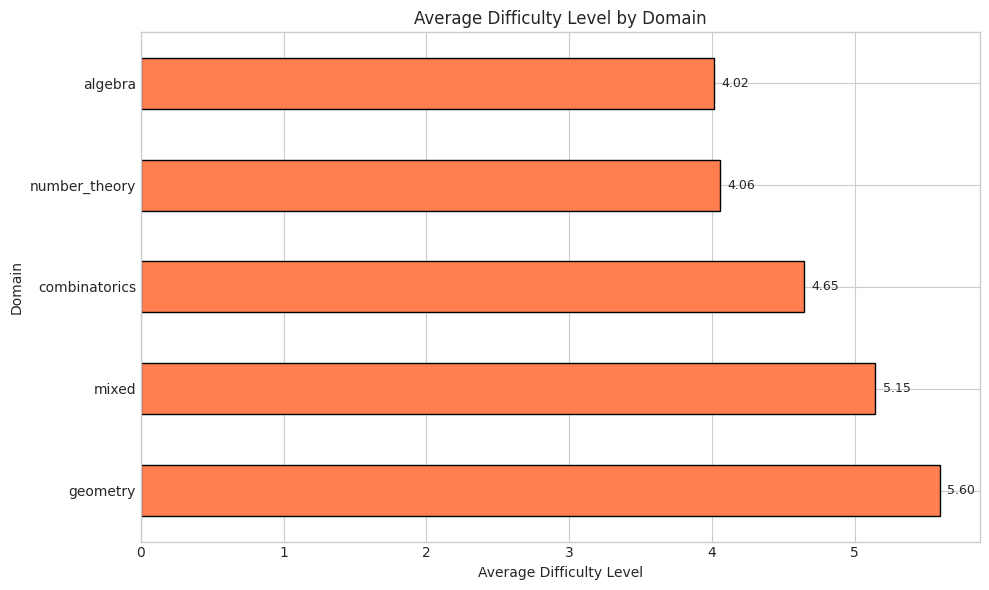

In [50]:
# Cross-tabulation: Domain vs Difficulty Level
if 'domain' in df.columns and 'difficulty_level' in df.columns:
    df_valid = df[df['domain'].notna() & df['difficulty_level'].notna()].copy()
    if len(df_valid) > 0:
        print(f"\nRecords with both domain and difficulty: {len(df_valid):,}")
        
        cross_tab = pd.crosstab(df_valid['domain'], df_valid['difficulty_level'])
        print("\nDomain vs Difficulty Level:")
        print(cross_tab)
        
        # Heatmap
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Count'})
        ax.set_title('Domain vs Difficulty Level Heatmap')
        ax.set_xlabel('Difficulty Level')
        ax.set_ylabel('Domain')
        plt.tight_layout()
        plt.show()
        
        # Average difficulty by domain
        avg_diff_by_domain = df_valid.groupby('domain')['difficulty_level'].agg(['mean', 'median', 'count'])
        avg_diff_by_domain = avg_diff_by_domain.sort_values('mean', ascending=False)
        print("\nAverage Difficulty by Domain:")
        print(avg_diff_by_domain)
        
        # Plot average difficulty
        fig, ax = plt.subplots(figsize=(10, 6))
        avg_diff_by_domain['mean'].plot(kind='barh', ax=ax, color='coral', edgecolor='black')
        ax.set_xlabel('Average Difficulty Level')
        ax.set_ylabel('Domain')
        ax.set_title('Average Difficulty Level by Domain')
        for i, v in enumerate(avg_diff_by_domain['mean'].values):
            ax.text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data for cross-tabulation")
else:
    print("Domain or difficulty level data not available")

## Text Complexity Analysis


Records with text complexity data: 71,761

Text Complexity Statistics:
       mechanisms_count  constraints_count  objects_count
count      71761.000000       71761.000000   71761.000000
mean           0.001059           1.617926       1.634802
std            0.032526           0.990748       0.697226
min            0.000000           0.000000       0.000000
25%            0.000000           1.000000       1.000000
50%            0.000000           2.000000       2.000000
75%            0.000000           2.000000       2.000000
max            1.000000          10.000000      10.000000


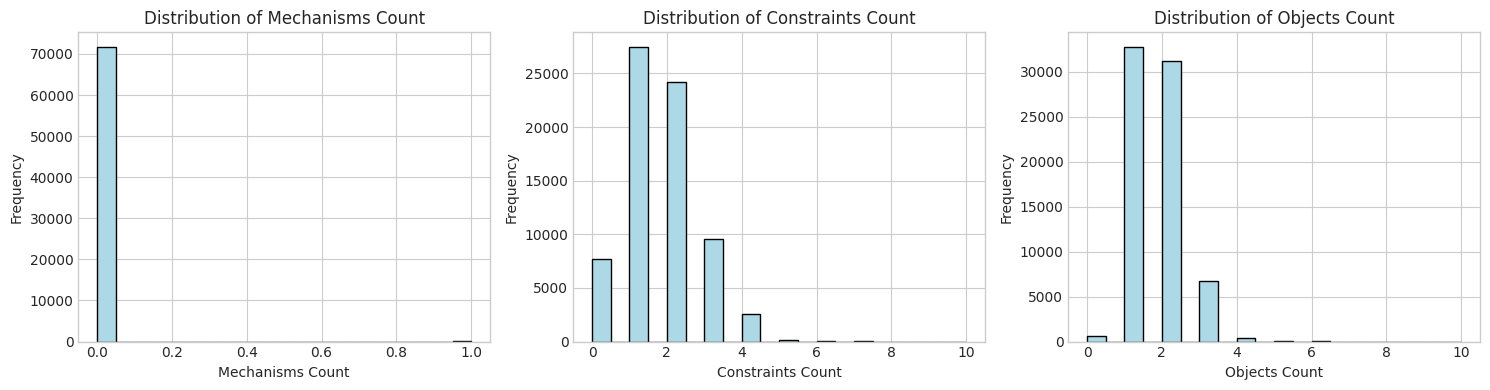


Correlation with Difficulty Level:
  mechanisms_count: -0.009
  constraints_count: 0.216
  objects_count: 0.197


In [51]:
# Analyze mechanisms, constraints, and objects counts
if all(col in df.columns for col in ['mechanisms_count', 'constraints_count', 'objects_count']):
    df_with_counts = df[
        df['mechanisms_count'].notna() & 
        df['constraints_count'].notna() & 
        df['objects_count'].notna()
    ].copy()
else:
    df_with_counts = pd.DataFrame()

if len(df_with_counts) > 0:
    print(f"\nRecords with text complexity data: {len(df_with_counts):,}")
    print("\nText Complexity Statistics:")
    print(df_with_counts[['mechanisms_count', 'constraints_count', 'objects_count']].describe())
    
    # Plot distributions
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, col in enumerate(['mechanisms_count', 'constraints_count', 'objects_count']):
        df_with_counts[col].hist(bins=20, ax=axes[idx], edgecolor='black', color='lightblue')
        axes[idx].set_xlabel(col.replace('_', ' ').title())
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation with difficulty
    if 'difficulty_level' in df_with_counts.columns:
        df_corr = df_with_counts[df_with_counts['difficulty_level'].notna()].copy()
        if len(df_corr) > 0:
            print("\nCorrelation with Difficulty Level:")
            for col in ['mechanisms_count', 'constraints_count', 'objects_count']:
                corr = df_corr[col].corr(df_corr['difficulty_level'])
                print(f"  {col}: {corr:.3f}")
else:
    print("No text complexity data available")

## Constraints, Objects & Reasoning Depth vs Difficulty Level


Constraints Count vs Difficulty Level  (n=55,761)
        mean  median    std  count
level                             
0      0.900     1.0  0.779    570
1      1.193     1.0  0.817   2151
2      1.304     1.0  0.876  10510
3      1.433     1.0  0.903   7281
4      1.407     1.0  0.922   2360
5      1.578     2.0  0.949   9767
6      1.778     2.0  1.002  14793
7      1.798     2.0  1.014   8329


/tmp/ipykernel_278703/1639194864.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sub, x='level', y=col, ax=axes[0],


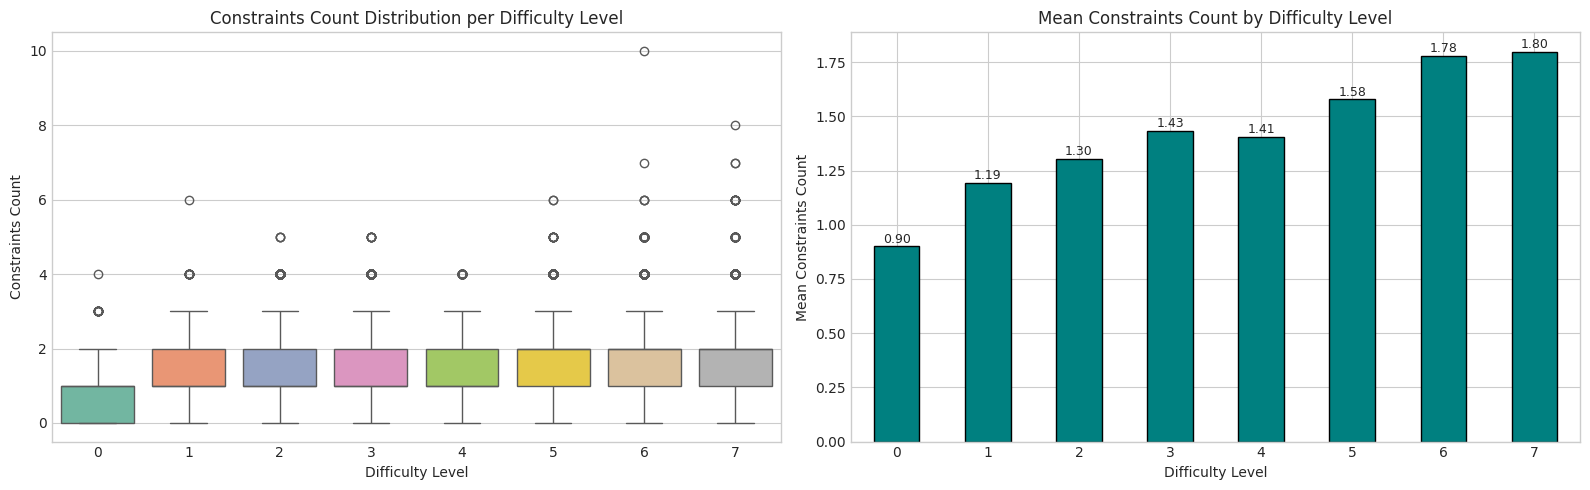


Objects Count vs Difficulty Level  (n=55,761)
        mean  median    std  count
level                             
0      1.295     1.0  0.497    570
1      1.378     1.0  0.519   2151
2      1.452     1.0  0.569  10510
3      1.492     1.0  0.596   7281
4      1.489     1.0  0.599   2360
5      1.549     2.0  0.624   9767
6      1.760     2.0  0.757  14793
7      1.764     2.0  0.737   8329


/tmp/ipykernel_278703/1639194864.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sub, x='level', y=col, ax=axes[0],


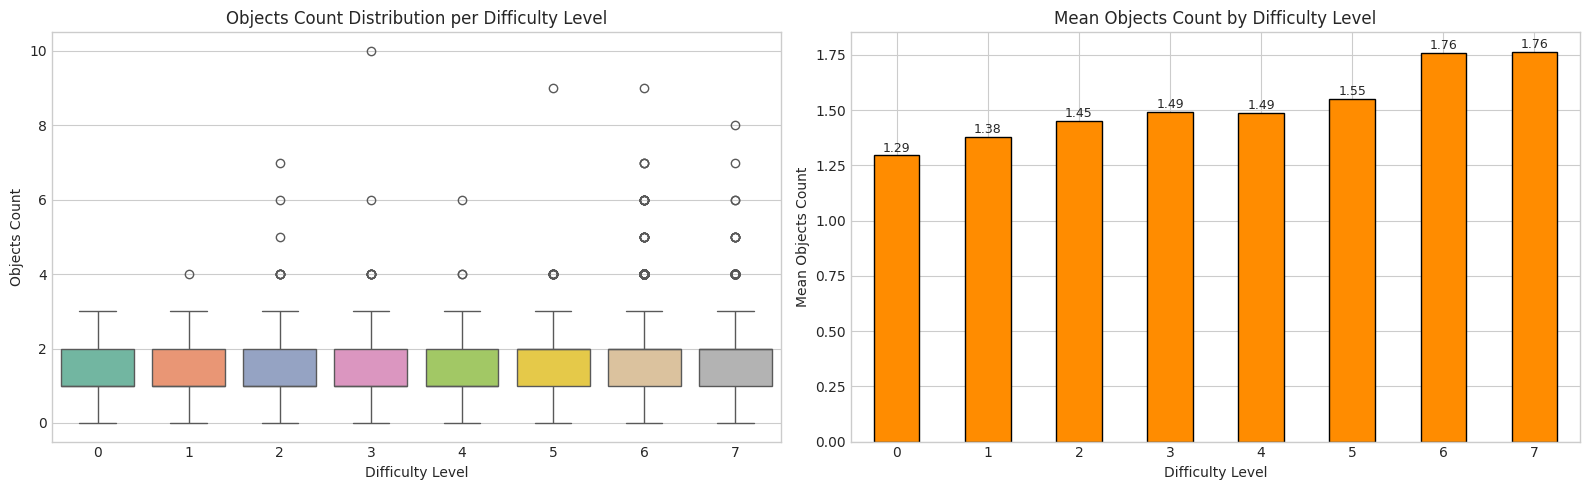


Reasoning Depth vs Difficulty Level  (n=55,515)

Counts:
difficulty_level  0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0
reasoning_depth                                                
deep               71   106   893   777   241  1184  2984  1606
medium            313   993  6198  4721  1495  6817  9880  5527
shallow           187  1034  3301  1716   610  1748  1920  1193

% within each difficulty level:
difficulty_level   0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0
reasoning_depth                                                 
deep              12.4   5.0   8.6  10.8  10.3  12.1  20.2  19.3
medium            54.8  46.6  59.6  65.4  63.7  69.9  66.8  66.4
shallow           32.7  48.5  31.8  23.8  26.0  17.9  13.0  14.3


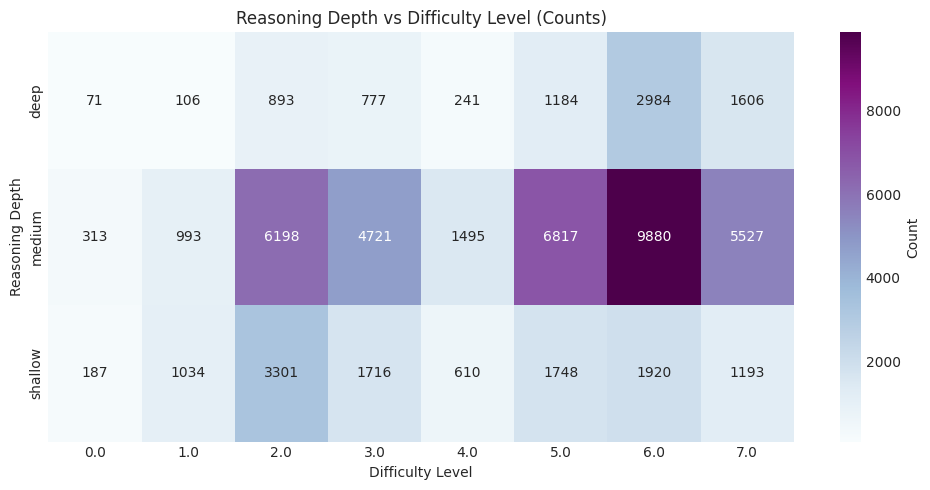

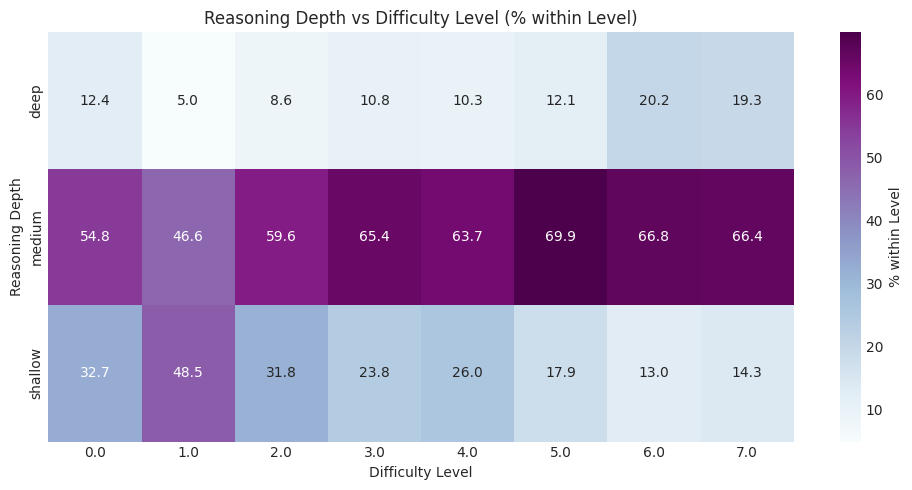

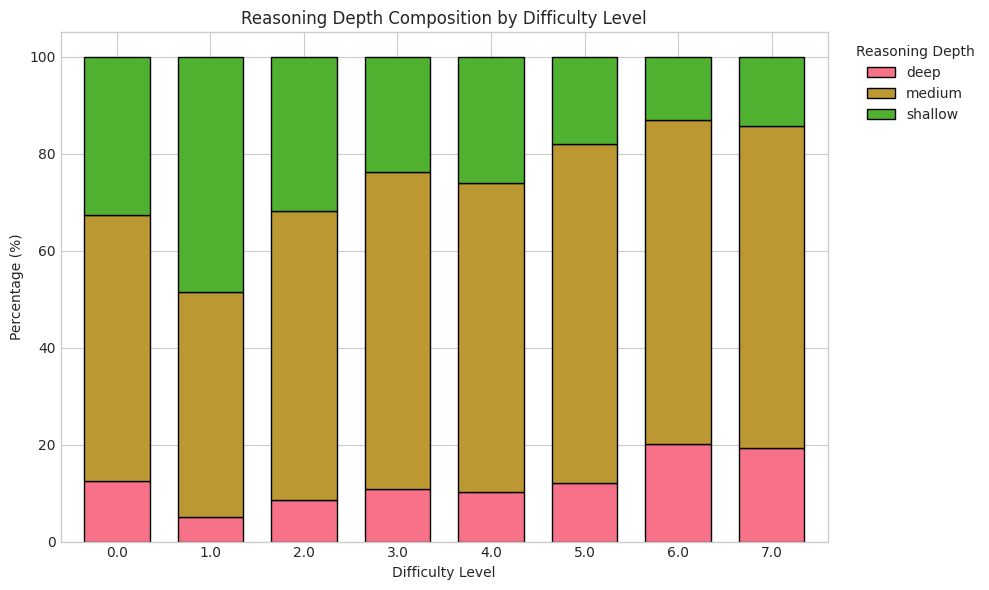

In [52]:
# ── Helper: numeric feature vs difficulty level breakdown ──
def plot_numeric_vs_difficulty(df, col, label, color='steelblue'):
    """Box plot + mean bar chart for a numeric column grouped by difficulty level."""
    df_sub = df[df[col].notna() & df['difficulty_level'].notna()].copy()
    df_sub['level'] = df_sub['difficulty_level'].astype(int)
    levels = sorted(df_sub['level'].unique())
    print(f"\n{'='*60}")
    print(f"{label} vs Difficulty Level  (n={len(df_sub):,})")
    print(f"{'='*60}")

    stats = df_sub.groupby('level')[col].agg(['mean', 'median', 'std', 'count'])
    print(stats.round(3))

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Box plot
    sns.boxplot(data=df_sub, x='level', y=col, ax=axes[0],
                order=levels, palette='Set2')
    axes[0].set_xlabel('Difficulty Level')
    axes[0].set_ylabel(label)
    axes[0].set_title(f'{label} Distribution per Difficulty Level')

    # Mean bar chart
    stats['mean'].plot(kind='bar', ax=axes[1], color=color, edgecolor='black')
    axes[1].set_xlabel('Difficulty Level')
    axes[1].set_ylabel(f'Mean {label}')
    axes[1].set_title(f'Mean {label} by Difficulty Level')
    for i, v in enumerate(stats['mean'].values):
        axes[1].text(i, v + stats['mean'].max() * 0.01, f'{v:.2f}', ha='center', fontsize=9)
    axes[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()


# ── Helper: categorical feature vs difficulty level breakdown ──
def plot_categorical_vs_difficulty(df, col, label, cmap='YlOrBr'):
    """Heatmap + stacked bar for a categorical column grouped by difficulty level."""
    df_sub = df[df[col].notna() & df['difficulty_level'].notna()].copy()
    # Remove null-like string values
    df_sub = df_sub[~df_sub[col].astype(str).str.lower().isin(['null', 'none', ''])]
    print(f"\n{'='*60}")
    print(f"{label} vs Difficulty Level  (n={len(df_sub):,})")
    print(f"{'='*60}")

    cross = pd.crosstab(df_sub[col], df_sub['difficulty_level'])
    cross_pct = pd.crosstab(df_sub[col], df_sub['difficulty_level'], normalize='columns') * 100
    print("\nCounts:")
    print(cross)
    print(f"\n% within each difficulty level:")
    print(cross_pct.round(1))

    # Counts heatmap
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(cross, annot=True, fmt='d', cmap=cmap, ax=ax,
                cbar_kws={'label': 'Count'})
    ax.set_title(f'{label} vs Difficulty Level (Counts)')
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel(label)
    plt.tight_layout()
    plt.show()

    # Percentage heatmap
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(cross_pct, annot=True, fmt='.1f', cmap=cmap, ax=ax,
                cbar_kws={'label': '% within Level'})
    ax.set_title(f'{label} vs Difficulty Level (% within Level)')
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel(label)
    plt.tight_layout()
    plt.show()

    # Stacked bar (composition per level)
    cross_pct_t = cross_pct.T
    fig, ax = plt.subplots(figsize=(10, 6))
    cross_pct_t.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', width=0.7)
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'{label} Composition by Difficulty Level')
    ax.legend(title=label, bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_ylim(0, 105)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


# ── 1. Constraints Count vs Difficulty Level ──
plot_numeric_vs_difficulty(df, 'constraints_count', 'Constraints Count', color='teal')

# ── 2. Objects Count vs Difficulty Level ──
plot_numeric_vs_difficulty(df, 'objects_count', 'Objects Count', color='darkorange')

# ── 3. Reasoning Depth vs Difficulty Level ──
plot_categorical_vs_difficulty(df, 'reasoning_depth', 'Reasoning Depth', cmap='BuPu')

## Solution Properties Analysis


Reasoning Depth Distribution:
reasoning_depth
medium     46182
shallow    14430
deep       10806
null           2
Name: count, dtype: int64


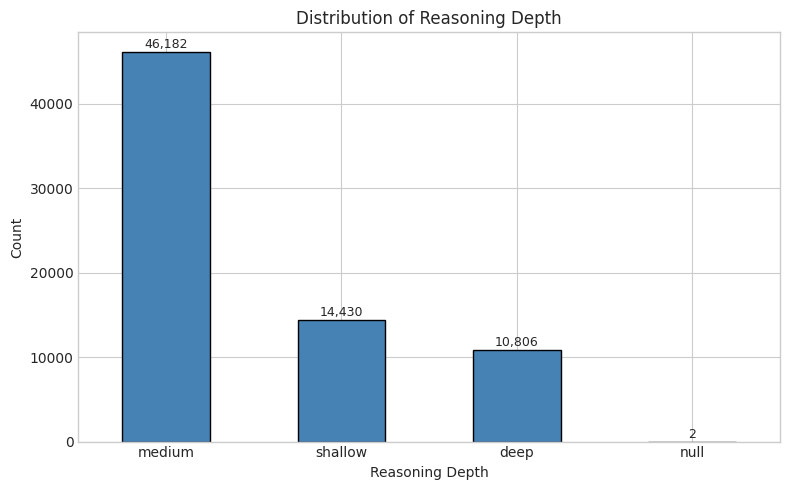


Reasoning Depth vs Difficulty Level:
difficulty_level  0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0
reasoning_depth                                                
deep               71   106   893   777   241  1184  2984  1606
medium            313   993  6198  4721  1495  6817  9880  5527
null                0     0     1     0     0     0     0     0
shallow           187  1034  3301  1716   610  1748  1920  1193


In [53]:
# Analyze reasoning depth
if 'reasoning_depth' in df.columns and df['reasoning_depth'].notna().any():
    depth_counts = df['reasoning_depth'].value_counts()
    print("\nReasoning Depth Distribution:")
    print(depth_counts)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    depth_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
    ax.set_xlabel('Reasoning Depth')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Reasoning Depth')
    plt.xticks(rotation=0)
    for i, v in enumerate(depth_counts.values):
        ax.text(i, v + max(depth_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
    
    # Reasoning depth vs difficulty
    if 'difficulty_level' in df.columns:
        df_rd = df[df['reasoning_depth'].notna() & df['difficulty_level'].notna()].copy()
        if len(df_rd) > 0:
            cross_tab_rd = pd.crosstab(df_rd['reasoning_depth'], df_rd['difficulty_level'])
            print("\nReasoning Depth vs Difficulty Level:")
            print(cross_tab_rd)
else:
    print("No reasoning depth data available")


Case Split Distribution:
case_split
none      68723
binary     2155
multi       574
null          1
Name: count, dtype: int64


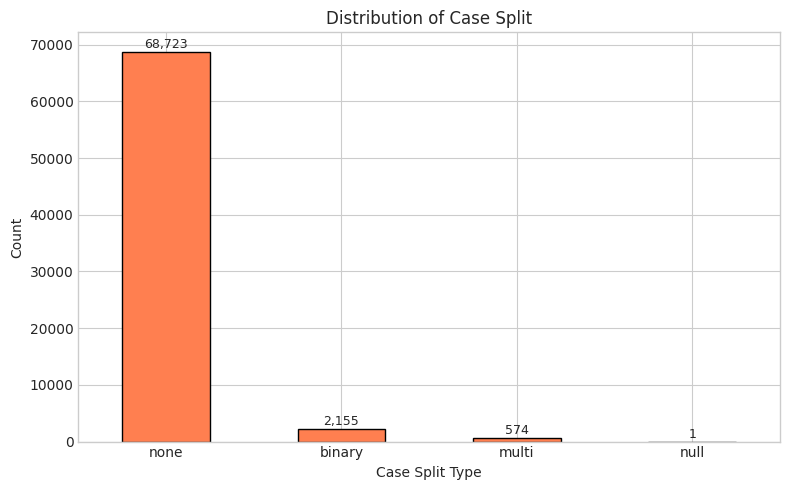

In [54]:
# Analyze case split
if 'case_split' in df.columns and df['case_split'].notna().any():
    case_split_counts = df['case_split'].value_counts()
    print("\nCase Split Distribution:")
    print(case_split_counts)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    case_split_counts.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
    ax.set_xlabel('Case Split Type')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Case Split')
    plt.xticks(rotation=0)
    for i, v in enumerate(case_split_counts.values):
        ax.text(i, v + max(case_split_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No case split data available")


Reasoning Shape Distribution:
reasoning_shape
linear                    70534
branching                   860
multi_branch_recombine       15
null                          2
deep                          1
none                          1
Name: count, dtype: int64


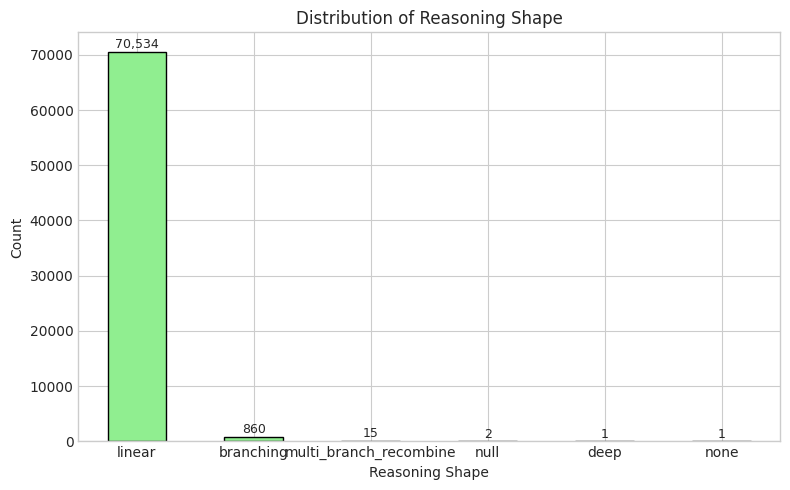

In [55]:
# Analyze reasoning shape
if 'reasoning_shape' in df.columns and df['reasoning_shape'].notna().any():
    shape_counts = df['reasoning_shape'].value_counts()
    print("\nReasoning Shape Distribution:")
    print(shape_counts)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    shape_counts.plot(kind='bar', ax=ax, color='lightgreen', edgecolor='black')
    ax.set_xlabel('Reasoning Shape')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Reasoning Shape')
    plt.xticks(rotation=0)
    for i, v in enumerate(shape_counts.values):
        ax.text(i, v + max(shape_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No reasoning shape data available")


Constraints Distribution (N >= 500):
constraints
equality            41370
exists              20149
inequality          12765
distinct            10196
forall               9773
bounded              7464
divisibility         6821
parity                824
positive_integer      687
integral              577
Name: count, dtype: int64


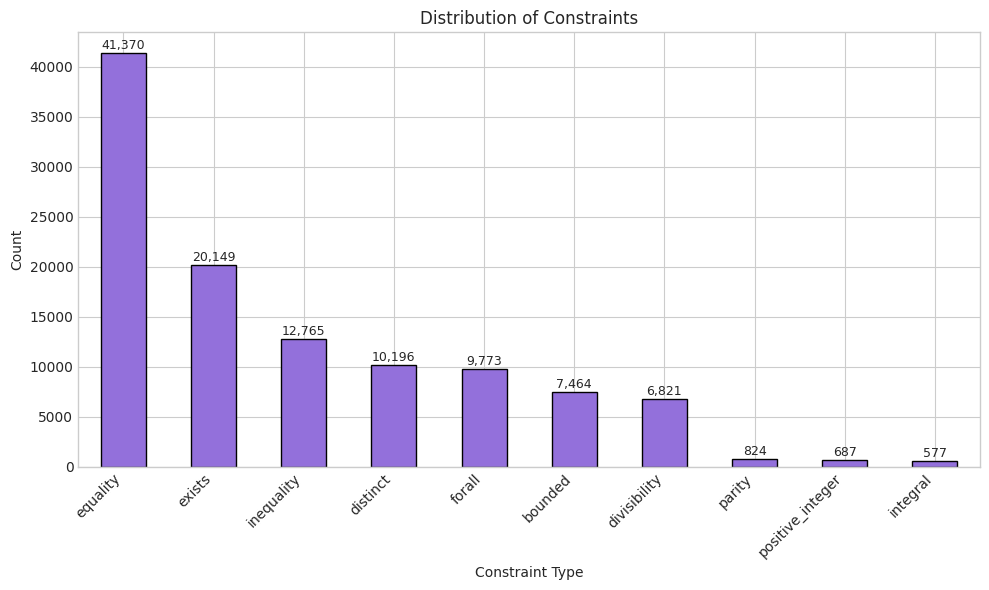


Note: 428 constraint types with fewer than 500 occurrences are excluded from visualizations. They are retained as distinct tags in the dataset.


In [56]:
# Analyze constraints distribution (individual constraint values from list field)
CONSTRAINT_MIN_COUNT = 500  # threshold for all constraint visualizations

if 'constraints' in df.columns and df['constraints'].apply(lambda x: isinstance(x, list) and len(x) > 0).any():
    all_constraints = df['constraints'].dropna().explode()
    all_constraints = all_constraints[all_constraints.apply(lambda x: isinstance(x, str) and x.strip() != '')]
    constraint_counts = all_constraints.value_counts()

    # Split by threshold
    constraint_counts_shown = constraint_counts[constraint_counts >= CONSTRAINT_MIN_COUNT]
    constraint_counts_excluded = constraint_counts[constraint_counts < CONSTRAINT_MIN_COUNT]

    print(f"\nConstraints Distribution (N >= {CONSTRAINT_MIN_COUNT}):")
    print(constraint_counts_shown)

    fig, ax = plt.subplots(figsize=(10, 6))
    constraint_counts_shown.plot(kind='bar', ax=ax, color='mediumpurple', edgecolor='black')
    ax.set_xlabel('Constraint Type')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Constraints')
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(constraint_counts_shown.values):
        ax.text(i, v + max(constraint_counts_shown.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()

    print(f"\nNote: {len(constraint_counts_excluded)} constraint types with fewer than {CONSTRAINT_MIN_COUNT} "
          f"occurrences are excluded from visualizations. They are retained as distinct tags in the dataset.")
else:
    print("No constraints data available")

Constraint-level pairs: 83,098  (9 constraint types shown, 330 excluded with N < 500)


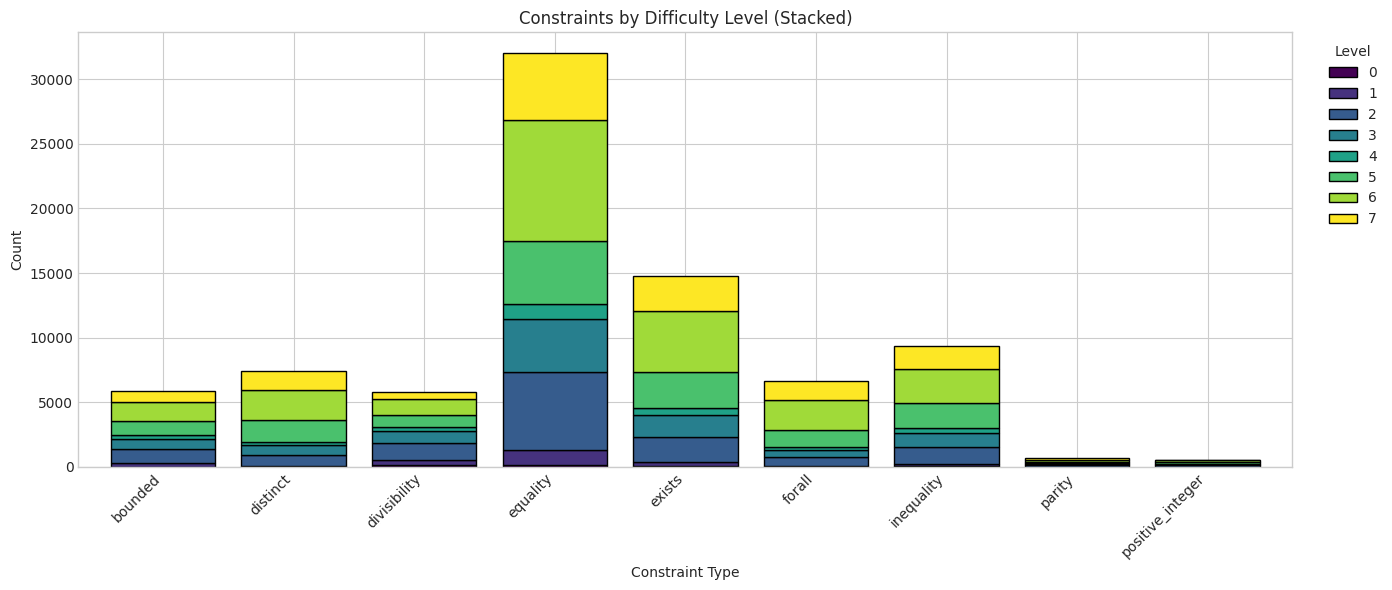

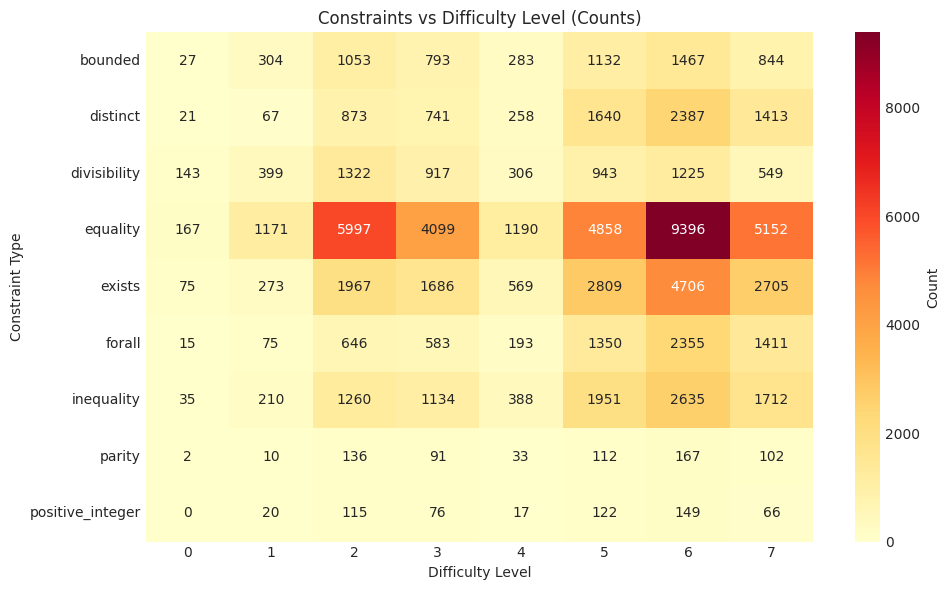

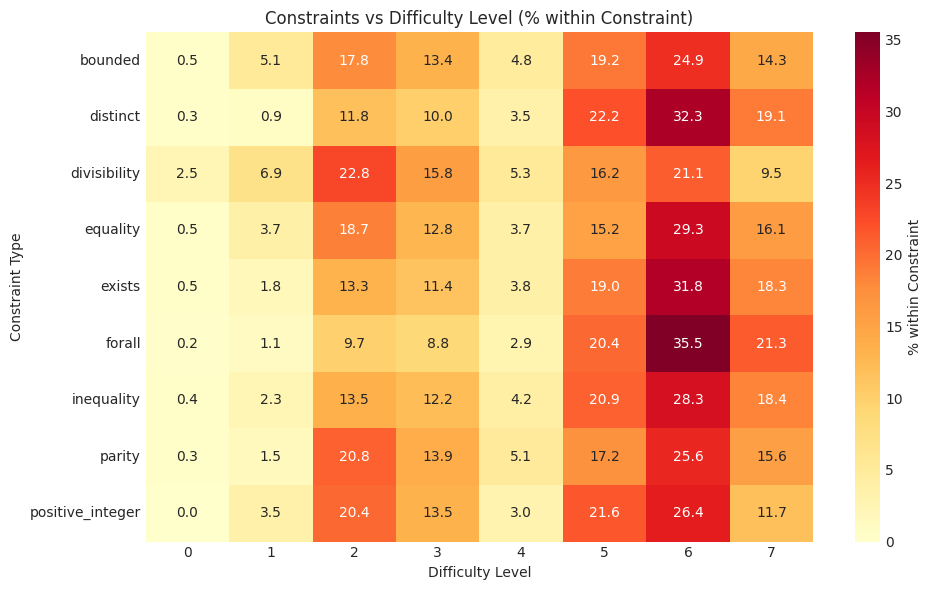

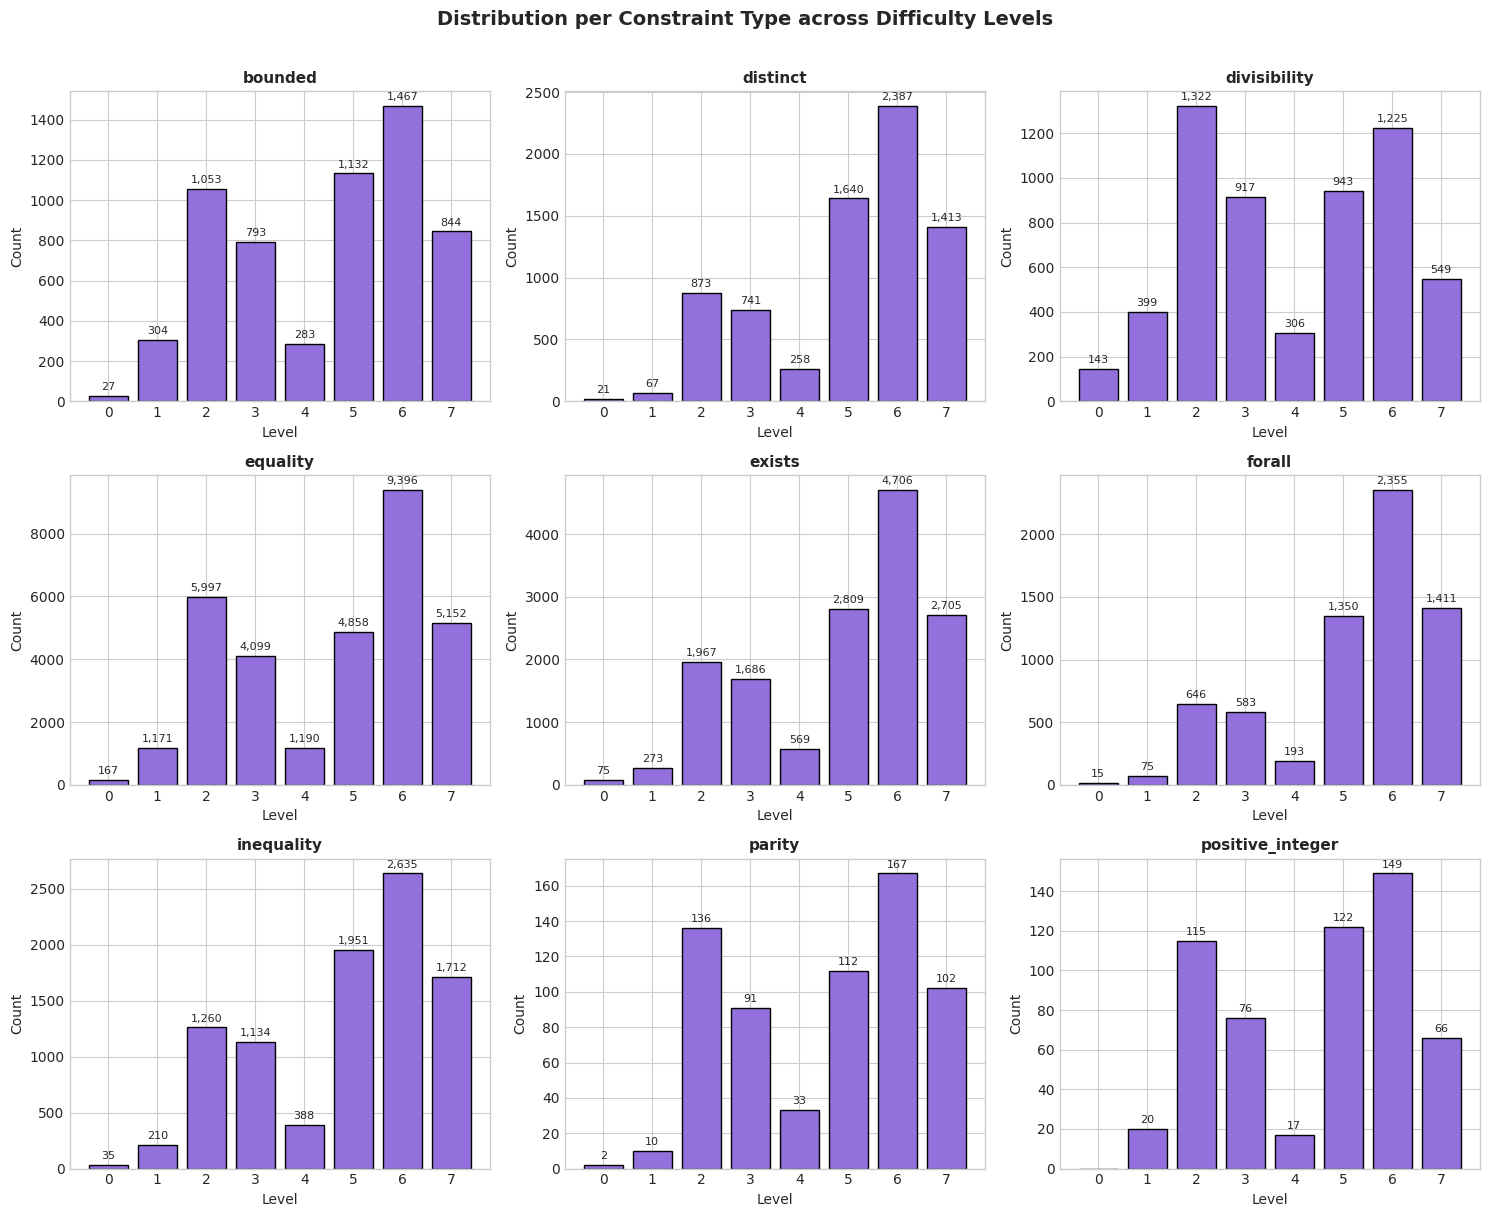

In [57]:
# ── Constraints vs Difficulty Level: 3 views ──
# Explode constraints and join with difficulty level
df_c = df[df['constraints'].apply(lambda x: isinstance(x, list) and len(x) > 0) & df['difficulty_level'].notna()].copy()
df_c['level'] = df_c['difficulty_level'].astype(int)

rows = []
for _, r in df_c.iterrows():
    for c in r['constraints']:
        if isinstance(c, str) and c.strip():
            rows.append({'constraint': c.strip(), 'level': r['level']})

df_exploded = pd.DataFrame(rows)

# Filter: only constraints with >= CONSTRAINT_MIN_COUNT total occurrences
constraint_totals = df_exploded['constraint'].value_counts()
valid_constraints = constraint_totals[constraint_totals >= CONSTRAINT_MIN_COUNT].index
excluded_constraints = constraint_totals[constraint_totals < CONSTRAINT_MIN_COUNT]
df_exploded = df_exploded[df_exploded['constraint'].isin(valid_constraints)]
print(f"Constraint-level pairs: {len(df_exploded):,}  ({len(valid_constraints)} constraint types shown, "
      f"{len(excluded_constraints)} excluded with N < {CONSTRAINT_MIN_COUNT})")

cross = pd.crosstab(df_exploded['constraint'], df_exploded['level'])
cross_pct = pd.crosstab(df_exploded['constraint'], df_exploded['level'], normalize='index') * 100

# ── 1. Stacked bar chart (by level) ──
fig, ax = plt.subplots(figsize=(14, 6))
cross.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', width=0.8, colormap='viridis')
ax.set_xlabel('Constraint Type')
ax.set_ylabel('Count')
ax.set_title('Constraints by Difficulty Level (Stacked)')
ax.legend(title='Level', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ── 2a. Heatmap — Counts ──
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cross, annot=True, fmt='d', cmap='YlOrRd', ax=ax,
            cbar_kws={'label': 'Count'})
ax.set_title('Constraints vs Difficulty Level (Counts)')
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Constraint Type')
plt.tight_layout()
plt.show()

# ── 2b. Heatmap — % within Constraint ──
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cross_pct, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
            cbar_kws={'label': '% within Constraint'})
ax.set_title('Constraints vs Difficulty Level (% within Constraint)')
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Constraint Type')
plt.tight_layout()
plt.show()

# ── 3. Small multiples (one chart per constraint) ──
constraint_types = sorted(cross.index.tolist())
n_constraints = len(constraint_types)
ncols = 3
nrows = int(np.ceil(n_constraints / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=False)
axes_flat = axes.flatten() if n_constraints > 1 else [axes]

for i, ctype in enumerate(constraint_types):
    ax = axes_flat[i]
    vals = cross.loc[ctype]
    ax.bar(vals.index.astype(str), vals.values, color='mediumpurple', edgecolor='black')
    ax.set_title(ctype, fontsize=11, fontweight='bold')
    ax.set_xlabel('Level')
    ax.set_ylabel('Count')
    for j, v in enumerate(vals.values):
        if v > 0:
            ax.text(j, v + max(vals.values) * 0.02, f'{v:,}', ha='center', fontsize=8)

# Hide unused axes
for k in range(n_constraints, len(axes_flat)):
    axes_flat[k].set_visible(False)

plt.suptitle('Distribution per Constraint Type across Difficulty Levels',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

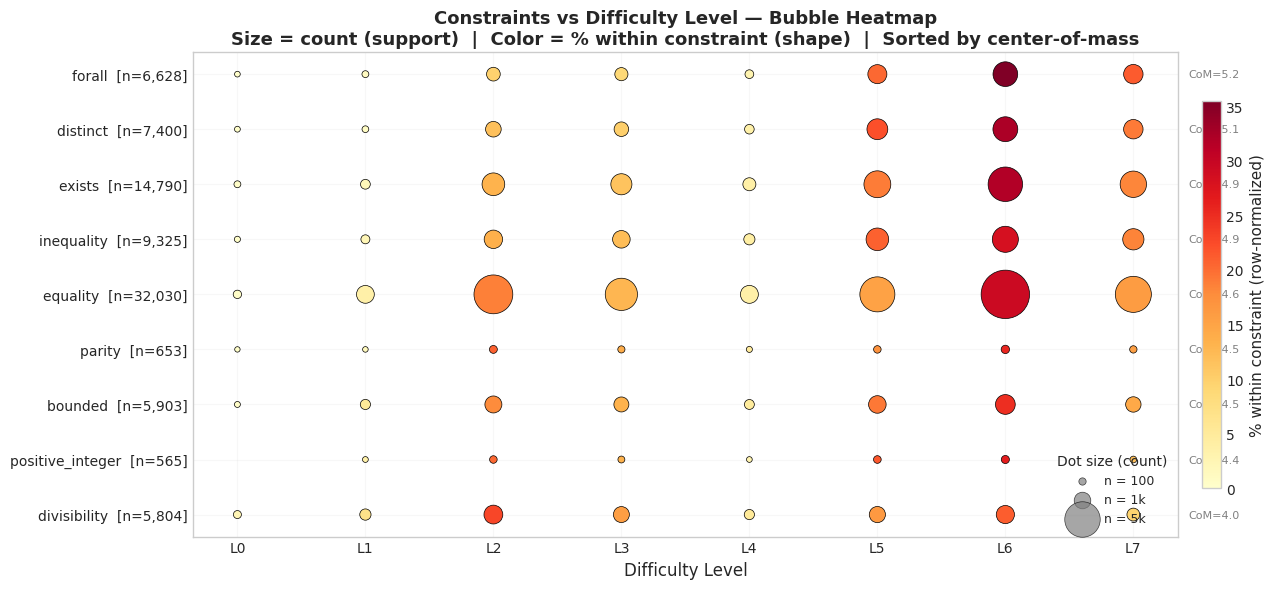

In [58]:
# ── Bubble Heatmap: Constraints vs Difficulty Level ──
# Dot size = raw count (support), dot color = % within constraint (shape).
# Rows sorted by center-of-mass level (constraints skewing hard at top).
# Constraints with N < CONSTRAINT_MIN_COUNT already filtered in cross/cross_pct above.

# Center-of-mass: weighted mean level per constraint (for sorting)
com = (cross.multiply(cross.columns, axis=1).sum(axis=1) / cross.sum(axis=1))
constraint_order = com.sort_values(ascending=False).index.tolist()  # hardest at top

# Total count per constraint (for annotation)
totals = cross.sum(axis=1)

# Build scatter data
scatter_levels = []
scatter_constraints = []
scatter_sizes = []
scatter_colors = []

for yi, ctype in enumerate(constraint_order):
    for L in cross.columns:
        count = cross.loc[ctype, L]
        pct = cross_pct.loc[ctype, L] if count > 0 else 0
        scatter_levels.append(L)
        scatter_constraints.append(yi)
        scatter_sizes.append(count)
        scatter_colors.append(pct)

scatter_sizes = np.array(scatter_sizes, dtype=float)
scatter_colors = np.array(scatter_colors, dtype=float)

# Scale dot sizes: map count range to visible dot area
max_count = scatter_sizes.max() if scatter_sizes.max() > 0 else 1
size_scaled = (scatter_sizes / max_count) * 1200 + 15  # min dot = 15, max = 1215
size_scaled[scatter_sizes == 0] = 0

fig, ax = plt.subplots(figsize=(14, max(6, len(constraint_order) * 0.55)))

sc = ax.scatter(scatter_levels, scatter_constraints,
                s=size_scaled, c=scatter_colors,
                cmap='YlOrRd', edgecolors='black', linewidths=0.5,
                vmin=0, vmax=max(scatter_colors.max(), 1), zorder=3)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.02, shrink=0.8)
cbar.set_label('% within constraint (row-normalized)', fontsize=11)

# Y-axis: constraint names + total count annotation
ax.set_yticks(range(len(constraint_order)))
ylabels = [f'{ctype}  [n={int(totals[ctype]):,}]' for ctype in constraint_order]
ax.set_yticklabels(ylabels, fontsize=10)
ax.invert_yaxis()

# X-axis
ax.set_xticks(cross.columns)
ax.set_xticklabels([f'L{l}' for l in cross.columns])
ax.set_xlabel('Difficulty Level', fontsize=12)

# Annotate center-of-mass on the right
for yi, ctype in enumerate(constraint_order):
    ax.annotate(f'CoM={com[ctype]:.1f}', xy=(1.01, yi),
                xycoords=('axes fraction', 'data'),
                fontsize=8, color='grey', va='center')

ax.set_title('Constraints vs Difficulty Level — Bubble Heatmap\n'
             'Size = count (support)  |  Color = % within constraint (shape)  |  Sorted by center-of-mass',
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.15)

# Size legend (manual)
for ref_count, label in [(100, '100'), (1000, '1k'), (5000, '5k')]:
    if ref_count <= max_count:
        ax.scatter([], [], s=(ref_count / max_count) * 1200 + 15,
                   c='grey', edgecolors='black', linewidths=0.5, alpha=0.7,
                   label=f'n = {label}')
ax.legend(title='Dot size (count)', loc='lower right', fontsize=9,
          framealpha=0.9, title_fontsize=10)

plt.tight_layout()
plt.show()

Excluded constraints (N < 200): 


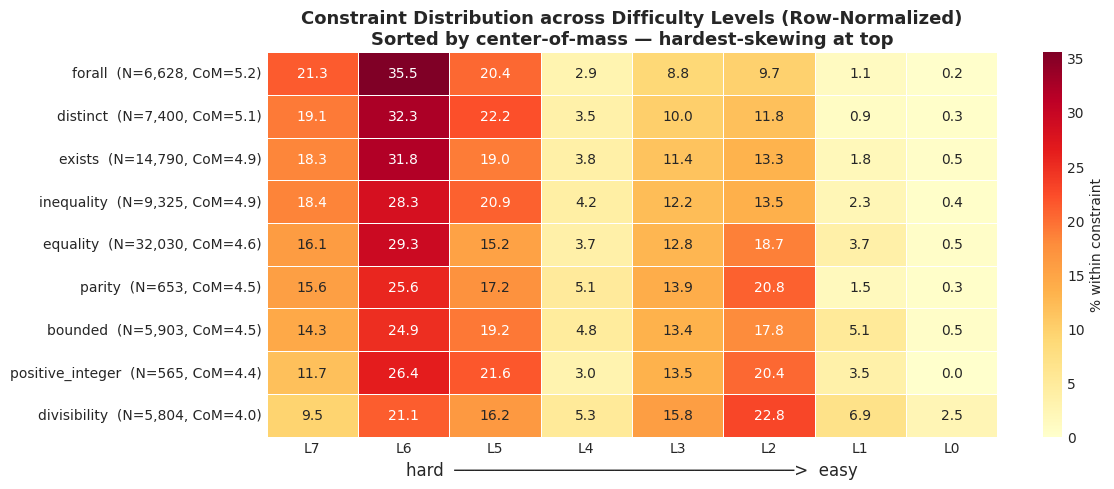


Note: Constraints with fewer than 200 occurrences () are excluded
from this visualization due to insufficient statistical support. They are retained as
distinct tags in the dataset.


In [59]:
# ── Row-Normalized Heatmap, Sorted by Difficulty Center-of-Mass ──
# Reuse cross, cross_pct, com, totals from cells above.

# Filter out constraints with fewer than 200 occurrences
min_count = 200
excluded = totals[totals < min_count].index.tolist()
kept = [c for c in com.sort_values(ascending=False).index if c not in excluded]

print(f"Excluded constraints (N < {min_count}): {', '.join(f'{c} (N={int(totals[c])})' for c in excluded)}")

# Build display matrix with reversed columns (L7..L0 = hard → easy)
heatmap_data = cross_pct.loc[kept]
heatmap_data = heatmap_data[sorted(heatmap_data.columns, reverse=True)]  # L7, L6, ..., L0
row_labels = [f'{c}  (N={int(totals[c]):,}, CoM={com[c]:.1f})' for c in kept]

fig, ax = plt.subplots(figsize=(12, max(5, len(kept) * 0.5)))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
            linewidths=0.5, linecolor='white',
            cbar_kws={'label': '% within constraint'},
            yticklabels=row_labels,
            xticklabels=[f'L{int(l)}' for l in heatmap_data.columns])
ax.set_xlabel('hard  ──────────────────────────────────>  easy', fontsize=12)
ax.set_ylabel('')
ax.set_title('Constraint Distribution across Difficulty Levels (Row-Normalized)\n'
             'Sorted by center-of-mass — hardest-skewing at top',
             fontsize=13, fontweight='bold')
ax.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

print(f"\nNote: Constraints with fewer than {min_count} occurrences ({', '.join(excluded)}) are excluded")
print("from this visualization due to insufficient statistical support. They are retained as")
print("distinct tags in the dataset.")


Invariant Distribution:
invariant
none        70580
explicit      670
implicit      202
null            1
Name: count, dtype: int64


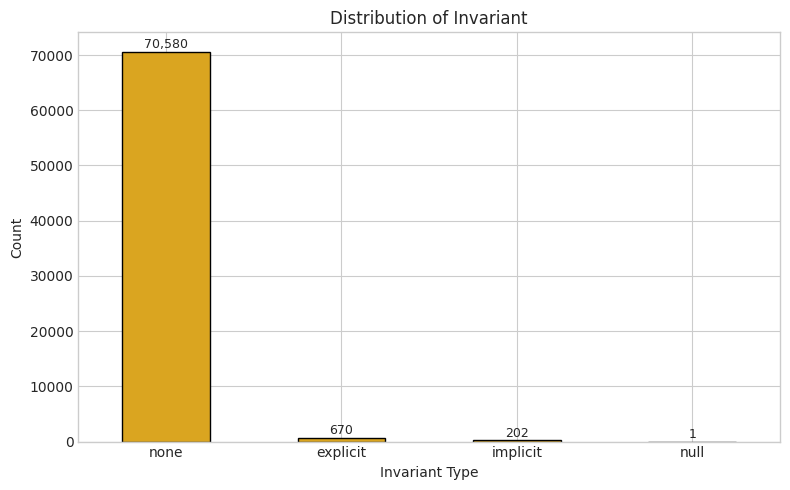

In [60]:
# Analyze invariant distribution
if 'invariant' in df.columns and df['invariant'].notna().any():
    invariant_counts = df['invariant'].value_counts()
    print("\nInvariant Distribution:")
    print(invariant_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    invariant_counts.plot(kind='bar', ax=ax, color='goldenrod', edgecolor='black')
    ax.set_xlabel('Invariant Type')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Invariant')
    plt.xticks(rotation=0)
    for i, v in enumerate(invariant_counts.values):
        ax.text(i, v + max(invariant_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No invariant data available")


Auxiliary Construction Distribution:
auxiliary_construction
symbolic      65498
none           4722
structural     1233
null              1
Name: count, dtype: int64


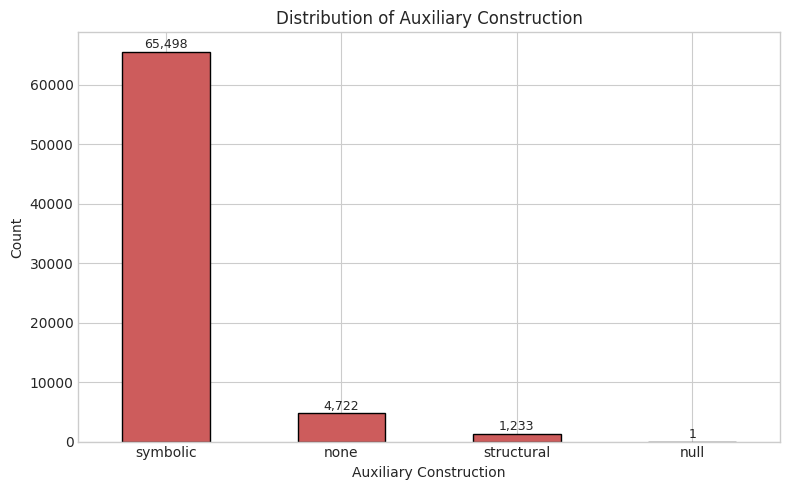

In [61]:
# Analyze auxiliary_construction distribution
if 'auxiliary_construction' in df.columns and df['auxiliary_construction'].notna().any():
    aux_counts = df['auxiliary_construction'].value_counts()
    print("\nAuxiliary Construction Distribution:")
    print(aux_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    aux_counts.plot(kind='bar', ax=ax, color='indianred', edgecolor='black')
    ax.set_xlabel('Auxiliary Construction')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Auxiliary Construction')
    plt.xticks(rotation=0)
    for i, v in enumerate(aux_counts.values):
        ax.text(i, v + max(aux_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No auxiliary_construction data available")


Technique Transitions Distribution:
technique_transitions
0       46180
1       12890
2       12400
3           1
null        1
Name: count, dtype: int64


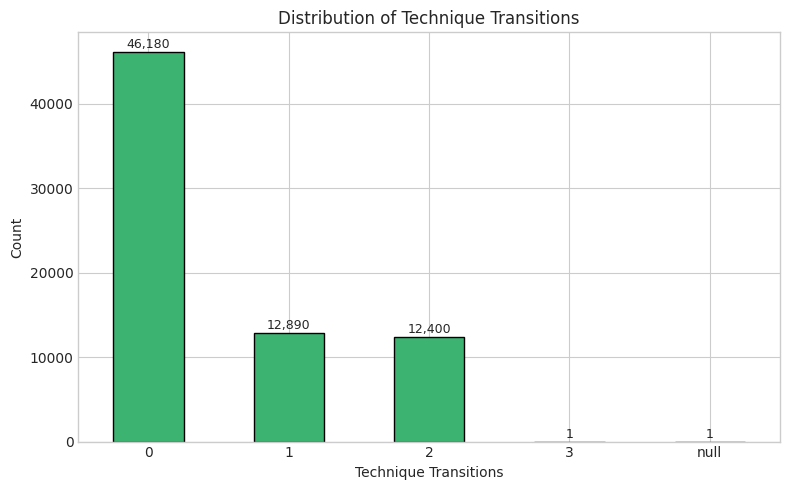

In [62]:
# Analyze technique_transitions distribution
if 'technique_transitions' in df.columns and df['technique_transitions'].notna().any():
    # Convert to string to handle mixed types, then get value counts
    tt_counts = df['technique_transitions'].astype(str).value_counts()
    
    # Try to sort numerically if possible, otherwise sort as strings
    try:
        # Attempt numeric sorting (puts integers first, then non-numeric strings)
        tt_counts = tt_counts.reindex(sorted(tt_counts.index, key=lambda x: (int(x) if x.isdigit() else float('inf'), x)))
    except (ValueError, TypeError):
        # Fall back to string sorting if numeric doesn't work
        tt_counts = tt_counts.sort_index()
    
    print("\nTechnique Transitions Distribution:")
    print(tt_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    tt_counts.plot(kind='bar', ax=ax, color='mediumseagreen', edgecolor='black')
    ax.set_xlabel('Technique Transitions')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Technique Transitions')
    plt.xticks(rotation=0)
    for i, v in enumerate(tt_counts.values):
        ax.text(i, v + max(tt_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No technique_transitions data available")


Argument Style Distribution:
argument_style
direct           69677
contradiction       79
none                49
inductive           12
null                 5
constructive         1
Name: count, dtype: int64


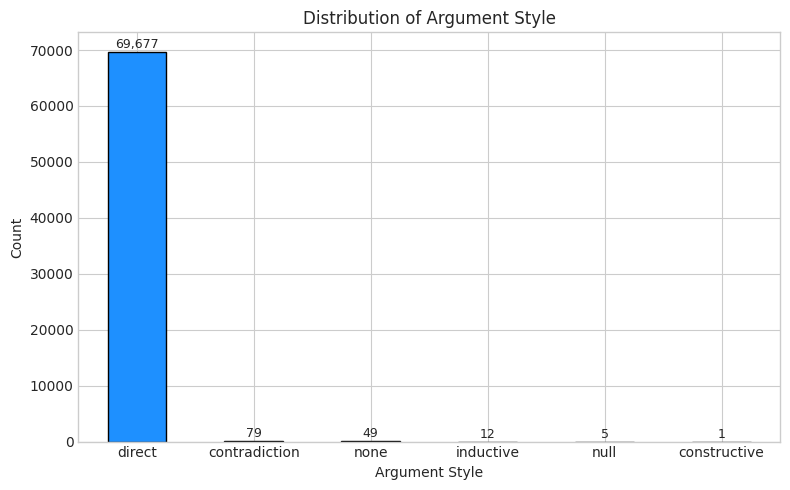

In [63]:
# Analyze argument_style distribution
if 'argument_style' in df.columns and df['argument_style'].notna().any():
    arg_counts = df['argument_style'].value_counts()
    print("\nArgument Style Distribution:")
    print(arg_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    arg_counts.plot(kind='bar', ax=ax, color='dodgerblue', edgecolor='black')
    ax.set_xlabel('Argument Style')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Argument Style')
    plt.xticks(rotation=0)
    for i, v in enumerate(arg_counts.values):
        ax.text(i, v + max(arg_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No argument_style data available")


Reasoning Scope Distribution:
reasoning_scope
local     56414
global    12976
mixed      2019
none          3
null          1
Name: count, dtype: int64


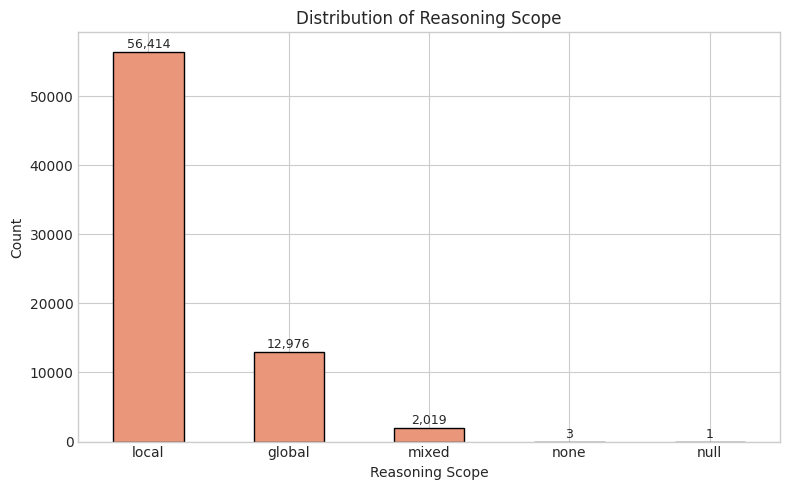

In [64]:
# Analyze reasoning_scope distribution
if 'reasoning_scope' in df.columns and df['reasoning_scope'].notna().any():
    scope_counts = df['reasoning_scope'].value_counts()
    print("\nReasoning Scope Distribution:")
    print(scope_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    scope_counts.plot(kind='bar', ax=ax, color='darksalmon', edgecolor='black')
    ax.set_xlabel('Reasoning Scope')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Reasoning Scope')
    plt.xticks(rotation=0)
    for i, v in enumerate(scope_counts.values):
        ax.text(i, v + max(scope_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No reasoning_scope data available")


Dead End Pruning Distribution:
dead_end_pruning
False    67712
True      3760
null         1
Name: count, dtype: int64


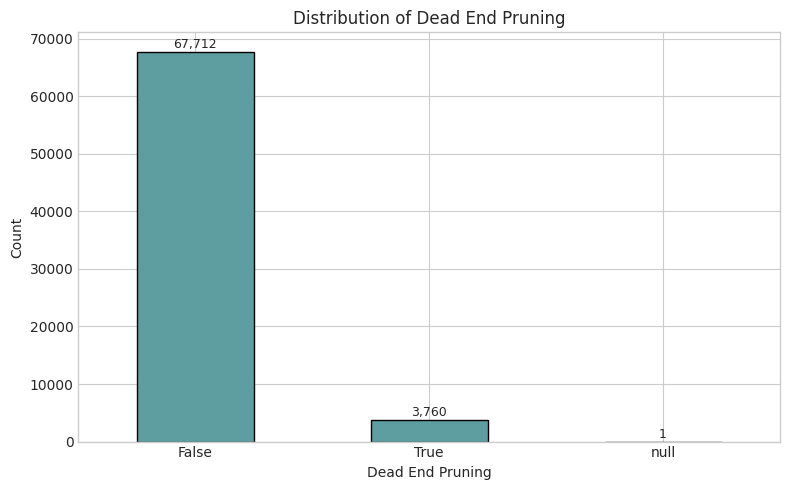

In [65]:
# Analyze dead_end_pruning distribution
if 'dead_end_pruning' in df.columns and df['dead_end_pruning'].notna().any():
    pruning_counts = df['dead_end_pruning'].value_counts()
    print("\nDead End Pruning Distribution:")
    print(pruning_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    pruning_counts.plot(kind='bar', ax=ax, color='cadetblue', edgecolor='black')
    ax.set_xlabel('Dead End Pruning')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Dead End Pruning')
    plt.xticks(rotation=0)
    for i, v in enumerate(pruning_counts.values):
        ax.text(i, v + max(pruning_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No dead_end_pruning data available")


Intermediate Reuse Distribution:
intermediate_reuse
single      33296
multiple    24107
none        14046
null            1
Name: count, dtype: int64


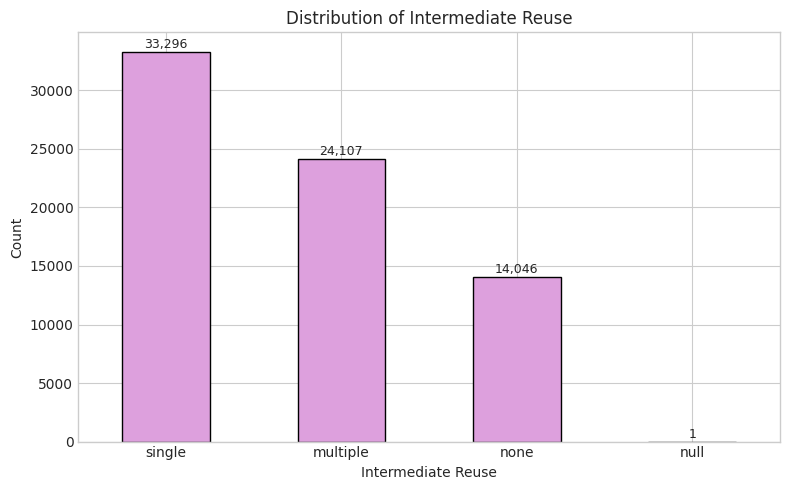

In [66]:
# Analyze intermediate_reuse distribution
if 'intermediate_reuse' in df.columns and df['intermediate_reuse'].notna().any():
    reuse_counts = df['intermediate_reuse'].value_counts()
    print("\nIntermediate Reuse Distribution:")
    print(reuse_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    reuse_counts.plot(kind='bar', ax=ax, color='plum', edgecolor='black')
    ax.set_xlabel('Intermediate Reuse')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Intermediate Reuse')
    plt.xticks(rotation=0)
    for i, v in enumerate(reuse_counts.values):
        ax.text(i, v + max(reuse_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No intermediate_reuse data available")

## Difficulty vs Reasoning Shape

Records with both difficulty and reasoning shape: 55,512

Difficulty Level vs Reasoning Shape (counts):
difficulty_level        0.0   1.0    2.0   3.0   4.0   5.0    6.0   7.0
reasoning_shape                                                        
branching                 0     5     55    53    20   130    226   108
linear                  571  2127  10335  7158  2323  9615  14555  8216
multi_branch_recombine    0     0      1     1     2     4      3     3
null                      0     0      1     0     0     0      0     0

Difficulty Level vs Reasoning Shape (% within difficulty level):
difficulty_level          0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0
reasoning_shape                                                        
branching                 0.0   0.2   0.5   0.7   0.9   1.3   1.5   1.3
linear                  100.0  99.8  99.5  99.3  99.1  98.6  98.5  98.7
multi_branch_recombine    0.0   0.0   0.0   0.0   0.1   0.0   0.0   0.0
null                      0.0   0.0   

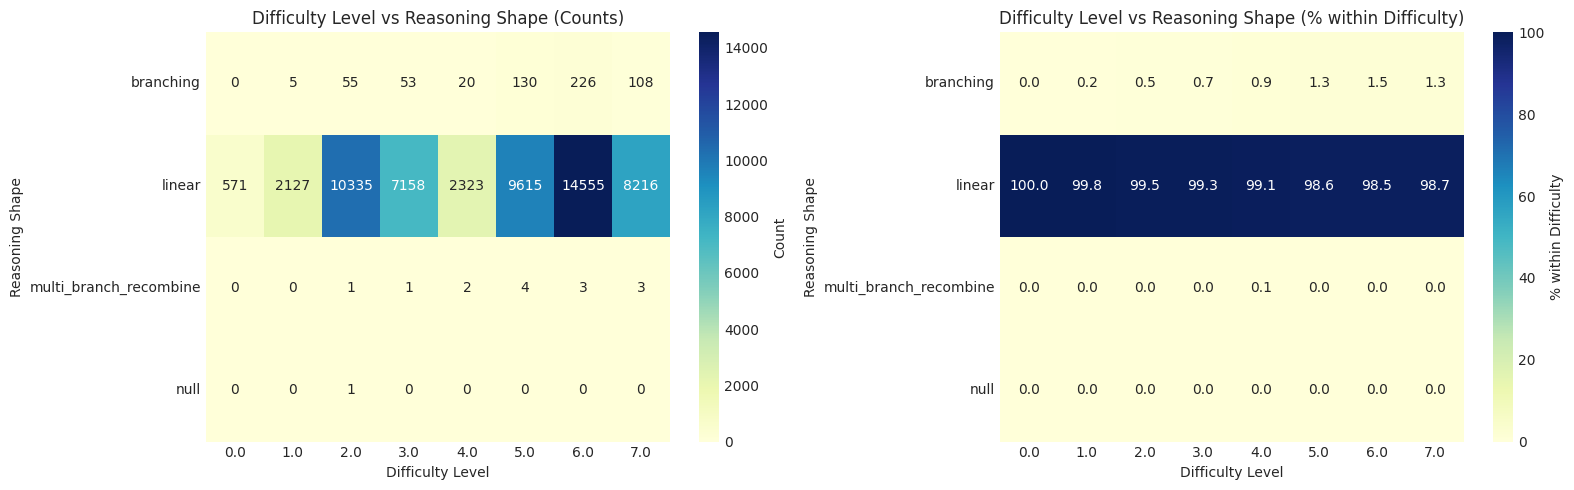

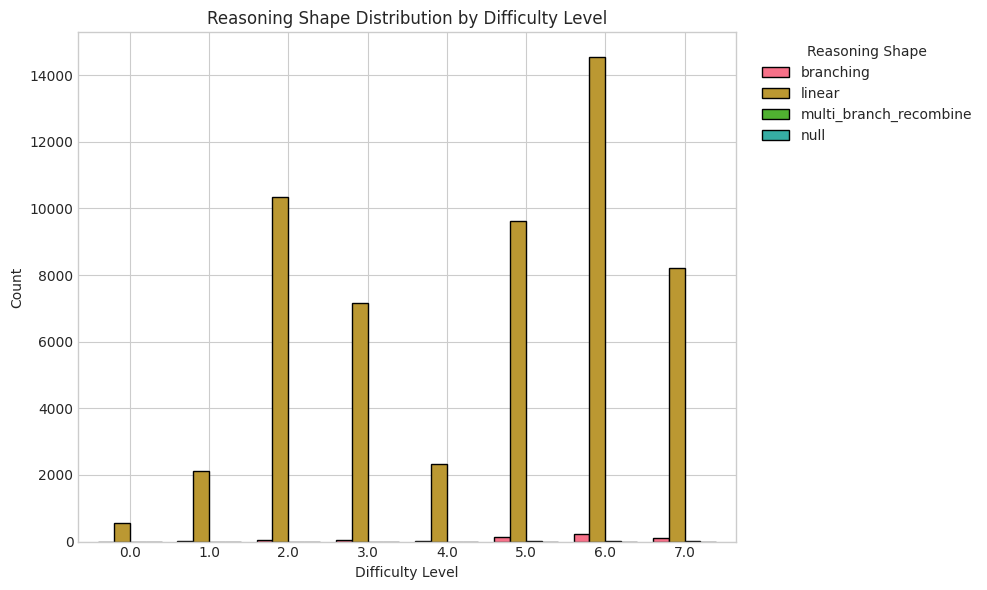

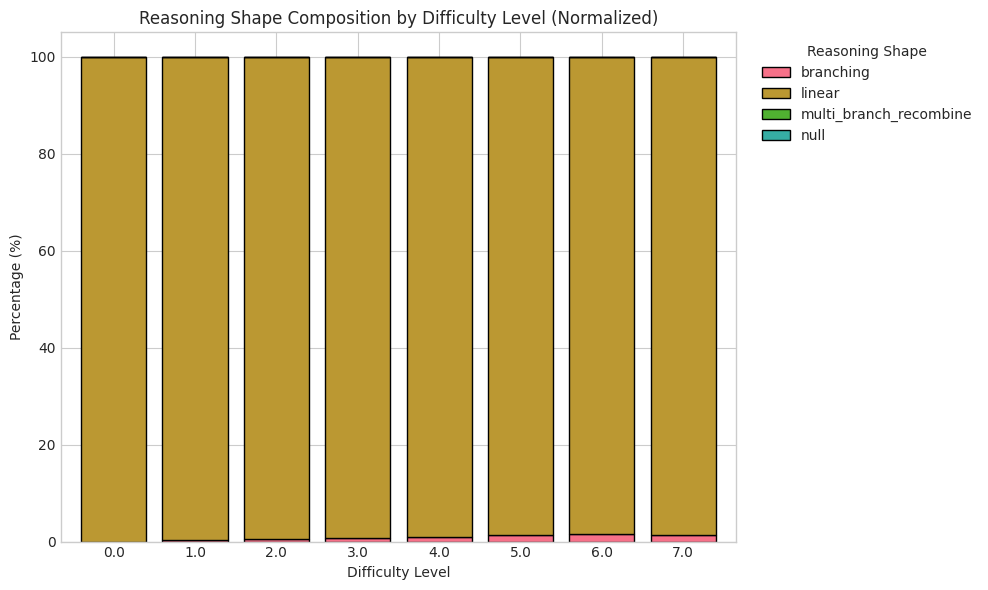

In [67]:
# Cross-tabulation: Difficulty Level vs Reasoning Shape
if 'difficulty_level' in df.columns and 'reasoning_shape' in df.columns:
    df_ds = df[df['difficulty_level'].notna() & df['reasoning_shape'].notna()].copy()
    print(f"Records with both difficulty and reasoning shape: {len(df_ds):,}")

    cross_tab_ds = pd.crosstab(df_ds['reasoning_shape'], df_ds['difficulty_level'])
    print("\nDifficulty Level vs Reasoning Shape (counts):")
    print(cross_tab_ds)

    # Normalized version (percentage within each difficulty level)
    cross_tab_ds_norm = pd.crosstab(df_ds['reasoning_shape'], df_ds['difficulty_level'], normalize='columns') * 100
    print("\nDifficulty Level vs Reasoning Shape (% within difficulty level):")
    print(cross_tab_ds_norm.round(1))

    # --- Plot 1: Heatmap (counts) ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    sns.heatmap(cross_tab_ds, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0],
                cbar_kws={'label': 'Count'})
    axes[0].set_title('Difficulty Level vs Reasoning Shape (Counts)')
    axes[0].set_xlabel('Difficulty Level')
    axes[0].set_ylabel('Reasoning Shape')

    sns.heatmap(cross_tab_ds_norm, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1],
                cbar_kws={'label': '% within Difficulty'})
    axes[1].set_title('Difficulty Level vs Reasoning Shape (% within Difficulty)')
    axes[1].set_xlabel('Difficulty Level')
    axes[1].set_ylabel('Reasoning Shape')

    plt.tight_layout()
    plt.show()

    # --- Plot 2: Grouped bar chart ---
    cross_tab_ds_plot = cross_tab_ds.T  # transpose so difficulty is on x-axis
    fig, ax = plt.subplots(figsize=(10, 6))
    cross_tab_ds_plot.plot(kind='bar', ax=ax, edgecolor='black', width=0.8)
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel('Count')
    ax.set_title('Reasoning Shape Distribution by Difficulty Level')
    ax.legend(title='Reasoning Shape', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: 100% stacked bar (composition within each difficulty) ---
    cross_tab_ds_pct = cross_tab_ds_norm.T  # transpose so difficulty is on x-axis
    fig, ax = plt.subplots(figsize=(10, 6))
    cross_tab_ds_pct.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', width=0.8)
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Reasoning Shape Composition by Difficulty Level (Normalized)')
    ax.legend(title='Reasoning Shape', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_ylim(0, 105)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Difficulty level or reasoning shape data not available")

## Metadata Extraction Quality: Missingness & Hallucination Audit

**Goal**: For every property we extract from `text` (problem statement) and `solution`, measure:
- **Success rate** — how often we get a meaningful, non-null value
- **Null %** — records where the field is entirely missing
- **Hallucination markers** — literal `"null"` strings, single-count outliers, degenerate distributions
- **Signal quality** — does the property actually discriminate, or is it 99%+ one value?

This tells us which metadata fields are **trustworthy for downstream use** (filtering, stratification, training signal) and which are **noise**.

In [68]:
# ─── Build the metadata quality audit table ───
# Uses `records` (raw JSONL) already loaded in cell above

def safe_get(rec, *keys):
    """Safely traverse nested dicts."""
    val = rec
    for k in keys:
        if not isinstance(val, dict):
            return None
        val = val.get(k)
    return val

N = len(records)

# All properties we extract, grouped by source
from_text_fields = {
    'domain':      {'type': 'scalar', 'none_is_valid': False},
    'objects':     {'type': 'list'},
    'constraints': {'type': 'list'},
    'mechanisms':  {'type': 'list'},
    'output_type': {'type': 'scalar', 'none_is_valid': False},
}

from_solution_fields = {
    'reasoning_shape':        {'type': 'scalar', 'none_is_valid': False},
    'case_split':             {'type': 'scalar', 'none_is_valid': True},
    'invariant':              {'type': 'scalar', 'none_is_valid': True},
    'auxiliary_construction': {'type': 'scalar', 'none_is_valid': True},
    'reasoning_depth':        {'type': 'scalar', 'none_is_valid': False},
    'technique_transitions':  {'type': 'scalar', 'none_is_valid': False},
    'argument_style':         {'type': 'scalar', 'none_is_valid': False},
    'reasoning_scope':        {'type': 'scalar', 'none_is_valid': True},
    'dead_end_pruning':       {'type': 'scalar', 'none_is_valid': False},
    'intermediate_reuse':     {'type': 'scalar', 'none_is_valid': True},
}

audit_rows = []

def analyze_field(values, field_name, source, field_meta):
    total = len(values)
    null_count = sum(1 for v in values if v is None)
    non_null = [v for v in values if v is not None]

    if field_meta['type'] == 'list':
        empty_list = sum(1 for v in non_null if v == [])
        populated = [v for v in non_null if v != []]
        all_items = [str(item) for v in populated for item in v]
        unique_items = set(all_items)
        ctr = Counter(all_items)

        null_str_count = sum(1 for item in all_items if item.lower() == 'null')
        singleton_items = sum(1 for v, c in ctr.items() if c == 1)

        success_rate = len(populated) / total * 100
        null_pct = null_count / total * 100
        empty_pct = empty_list / total * 100

        if all_items:
            top_val, top_count = ctr.most_common(1)[0]
            top_pct = top_count / len(all_items) * 100
        else:
            top_val, top_pct = 'n/a', 0

        audit_rows.append({
            'Source': source,
            'Property': field_name,
            'Type': 'list',
            'Success %': success_rate,
            'Null %': null_pct,
            'Empty/Degen %': empty_pct,
            '"null" halluc.': null_str_count,
            'Singletons': singleton_items,
            'Unique vals': len(unique_items),
            'Top value (%)': f'{top_val} ({top_pct:.0f}%)',
        })
    else:
        str_values = [str(v) for v in non_null]
        ctr = Counter(str_values)
        unique = set(str_values)

        null_str = sum(1 for v in str_values if v.lower() == 'null')
        none_halluc = 0
        if not field_meta.get('none_is_valid'):
            none_halluc = sum(1 for v in str_values if v.lower() == 'none')
        halluc = null_str + none_halluc

        singletons = sum(1 for v, c in ctr.items() if c == 1)
        success_rate = len(non_null) / total * 100
        null_pct = null_count / total * 100

        if str_values:
            top_val, top_count = ctr.most_common(1)[0]
            top_pct = top_count / len(str_values) * 100
        else:
            top_val, top_pct = 'n/a', 0

        # Degenerate = top value > 93% (nearly always one value)
        degen_pct = top_pct if top_pct > 93 else 0

        audit_rows.append({
            'Source': source,
            'Property': field_name,
            'Type': 'scalar',
            'Success %': success_rate,
            'Null %': null_pct,
            'Empty/Degen %': degen_pct,
            '"null" halluc.': halluc,
            'Singletons': singletons,
            'Unique vals': len(unique),
            'Top value (%)': f'{top_val} ({top_pct:.0f}%)',
        })

for field_name, meta in from_text_fields.items():
    values = [safe_get(r, 'math_structure', 'from_text', field_name) for r in records]
    analyze_field(values, field_name, 'text', meta)

for field_name, meta in from_solution_fields.items():
    values = [safe_get(r, 'math_structure', 'from_solution', field_name) for r in records]
    analyze_field(values, field_name, 'solution', meta)

audit_df = pd.DataFrame(audit_rows)

# Add verdict + reason columns
verdicts = {
    'domain':                 'KEEP',
    'objects':                'KEEP',
    'constraints':            'KEEP',
    'mechanisms':             'DROP',
    'output_type':            'KEEP',
    'reasoning_shape':        'DROP',
    'case_split':             'DROP',
    'invariant':              'DROP',
    'auxiliary_construction': 'REVIEW',
    'reasoning_depth':        'KEEP',
    'technique_transitions':  'KEEP',
    'argument_style':         'DROP',
    'reasoning_scope':        'KEEP',
    'dead_end_pruning':       'DROP',
    'intermediate_reuse':     'KEEP',
}
reasons = {
    'domain':                 'Good 5-class spread, 0.2% null',
    'objects':                'Rich vocab (320 types), 99% pop.',
    'constraints':            '89% populated, good diversity',
    'mechanisms':             '99.8% empty — nearly zero signal',
    'output_type':            '99% populated, useful for stratification',
    'reasoning_shape':        '98.7% linear — no discrimination',
    'case_split':             '95.7% none — low signal',
    'invariant':              '98.3% none — low signal',
    'auxiliary_construction': '91% symbolic — skewed, some signal',
    'reasoning_depth':        'Good 3-way: shallow/medium/deep',
    'technique_transitions':  'Meaningful spread 0/1/2',
    'argument_style':         '99.7% direct — degenerate',
    'reasoning_scope':        '79% local / 18% global — useful',
    'dead_end_pruning':       '94.3% False — low signal',
    'intermediate_reuse':     'Good 3-way: none/single/multiple',
}
audit_df['Verdict'] = audit_df['Property'].map(verdicts)
audit_df['Reason'] = audit_df['Property'].map(reasons)

def color_verdict(row):
    v = str(row.get('Verdict', ''))
    if v == 'DROP':
        return ['background-color: #ffe0e0'] * len(row)
    elif v == 'KEEP':
        return ['background-color: #e0ffe0'] * len(row)
    elif v == 'REVIEW':
        return ['background-color: #fff3cd'] * len(row)
    return [''] * len(row)

print(f"Metadata extraction quality audit — {N:,} raw records\n")
display(audit_df.style
    .format({
        'Success %': '{:.1f}%',
        'Null %': '{:.1f}%',
        'Empty/Degen %': '{:.1f}%',
        '"null" halluc.': '{:,}',
        'Singletons': '{:,}',
        'Unique vals': '{:,}',
    })
    .apply(color_verdict, axis=1)
    .set_properties(**{'text-align': 'left', 'font-size': '11px'})
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left'), ('font-size', '11px')]}])
)

Metadata extraction quality audit — 71,832 raw records



,Source,Property,Type,Success %,Null %,Empty/Degen %,"""null"" halluc.",Singletons,Unique vals,Top value (%),Verdict,Reason
0,text,domain,scalar,99.8%,0.2%,0.0%,0,0,5,number_theory (29%),KEEP,"Good 5-class spread, 0.2% null"
1,text,objects,list,99.0%,0.1%,0.9%,0,135,320,integer (34%),KEEP,"Rich vocab (320 types), 99% pop."
2,text,constraints,list,89.1%,0.1%,10.8%,0,237,438,equality (36%),KEEP,"89% populated, good diversity"
3,text,mechanisms,list,0.1%,0.1%,99.8%,0,4,7,algebraic_manipulation (49%),DROP,99.8% empty — nearly zero signal
4,text,output_type,scalar,98.9%,1.1%,0.0%,0,1,9,exact_value (75%),KEEP,"99% populated, useful for stratification"
5,solution,reasoning_shape,scalar,99.4%,0.6%,98.8%,3,2,6,linear (99%),DROP,98.7% linear — no discrimination
6,solution,case_split,scalar,99.5%,0.5%,96.2%,1,1,4,none (96%),DROP,95.7% none — low signal
7,solution,invariant,scalar,99.5%,0.5%,98.8%,1,1,4,none (99%),DROP,98.3% none — low signal
8,solution,auxiliary_construction,scalar,99.5%,0.5%,0.0%,1,1,4,symbolic (92%),REVIEW,"91% symbolic — skewed, some signal"
9,solution,reasoning_depth,scalar,99.4%,0.6%,0.0%,2,0,4,medium (65%),KEEP,Good 3-way: shallow/medium/deep


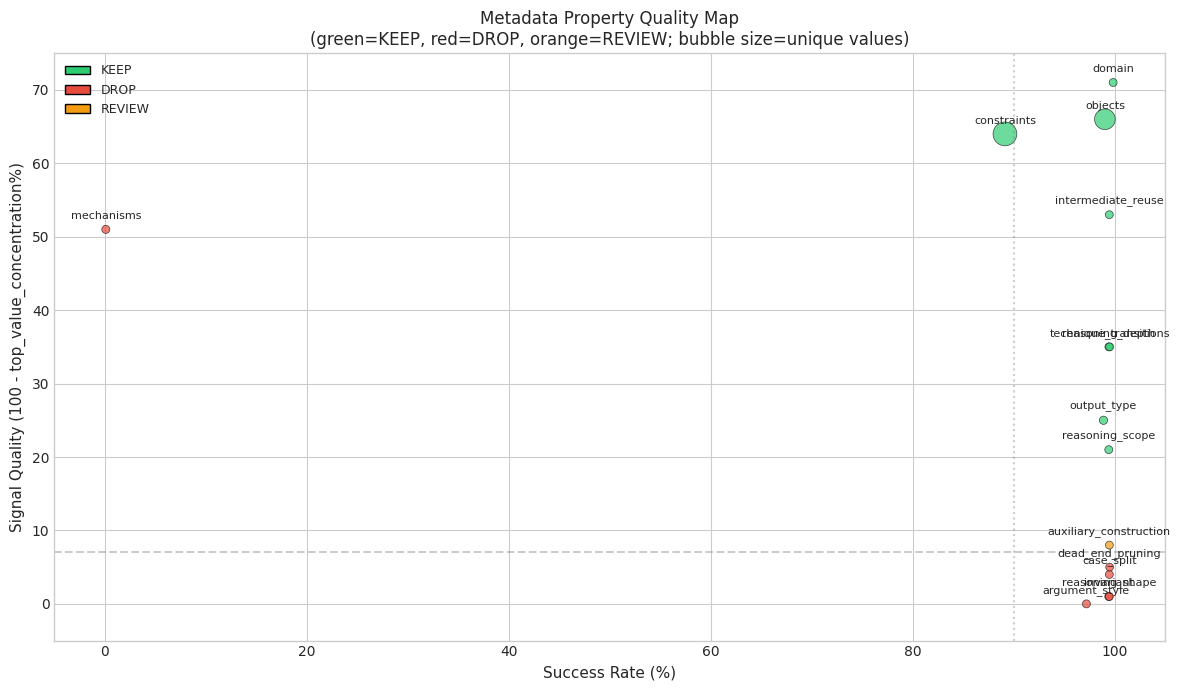

Upper-right quadrant (high success + high signal) = ideal for downstream use.
Lower-right (high success + low signal) = reliably extracted but degenerate.
Upper-left (low success) = too many missing values to be useful.


In [69]:
# ─── Visual: Success rate vs Signal quality (bubble = unique values) ───
import re

fig, ax = plt.subplots(figsize=(12, 7))

plot_data = audit_df.copy()
plot_data['top_pct'] = plot_data['Top value (%)'].apply(
    lambda x: float(re.search(r'\((\d+)%\)', x).group(1)) if re.search(r'\((\d+)%\)', x) else 0
)
plot_data['signal_quality'] = 100 - plot_data['top_pct']

colors = plot_data['Verdict'].map({'KEEP': '#2ecc71', 'DROP': '#e74c3c', 'REVIEW': '#f39c12'})
sizes = plot_data['Unique vals'].clip(upper=500) * 0.6 + 30

ax.scatter(plot_data['Success %'], plot_data['signal_quality'],
           c=colors, s=sizes, alpha=0.7, edgecolors='black', linewidth=0.5)

for _, row in plot_data.iterrows():
    ax.annotate(row['Property'], (row['Success %'], row['signal_quality']),
                fontsize=8, ha='center', va='bottom',
                xytext=(0, 6), textcoords='offset points')

ax.axhline(y=7, color='gray', linestyle='--', alpha=0.4)
ax.axvline(x=90, color='gray', linestyle=':', alpha=0.4)

ax.set_xlabel('Success Rate (%)', fontsize=11)
ax.set_ylabel('Signal Quality (100 - top_value_concentration%)', fontsize=11)
ax.set_title('Metadata Property Quality Map\n(green=KEEP, red=DROP, orange=REVIEW; bubble size=unique values)', fontsize=12)
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 75)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', edgecolor='black', label='KEEP'),
    Patch(facecolor='#e74c3c', edgecolor='black', label='DROP'),
    Patch(facecolor='#f39c12', edgecolor='black', label='REVIEW'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

print("Upper-right quadrant (high success + high signal) = ideal for downstream use.")
print("Lower-right (high success + low signal) = reliably extracted but degenerate.")
print("Upper-left (low success) = too many missing values to be useful.")

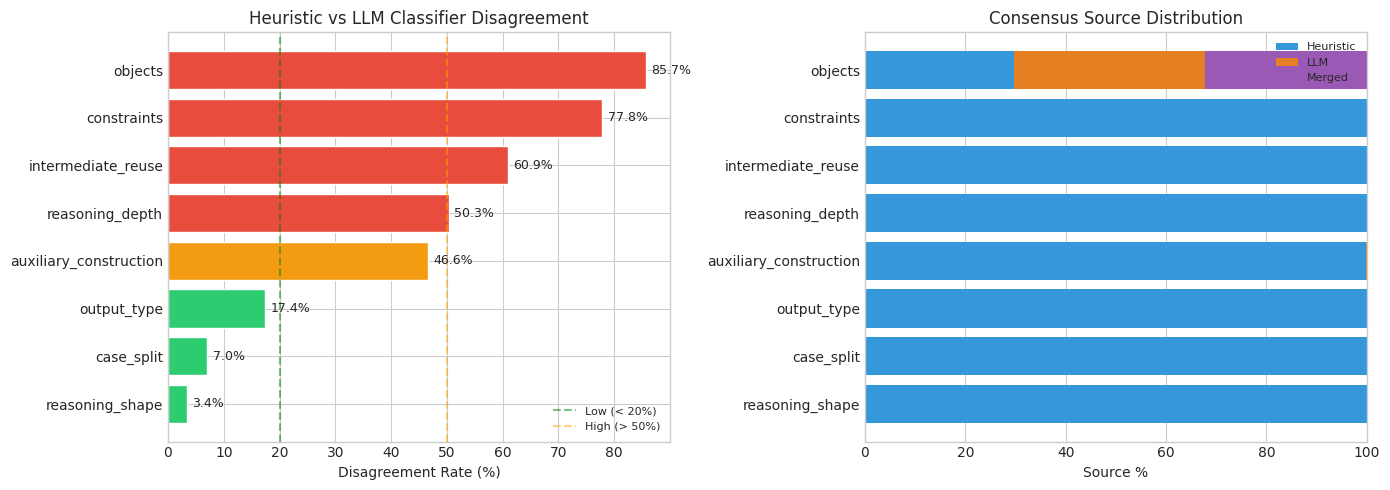

Key insight: objects and constraints have very high disagreement (78-86%),
meaning heuristic and LLM extraction produce substantially different results.
For these fields, the merged consensus is critical for quality.


In [70]:
# ─── Heuristic vs LLM Consensus Disagreement (from pipeline step 4) ───
# Disagreement rates when merging heuristic and LLM classifiers.
# Higher disagreement = less reliable extraction (the two methods don't agree).

consensus_data = {
    'Property': [
        'reasoning_shape', 'case_split', 'auxiliary_construction',
        'reasoning_depth', 'intermediate_reuse',
        'objects', 'constraints', 'output_type',
    ],
    'Heuristic': [71761, 71761, 71627, 71761, 71761, 21323, 71761, 71761],
    'LLM': [0, 0, 134, 0, 0, 27356, 0, 0],
    'Merged': [0, 0, 0, 0, 0, 23082, 0, 0],
    'Disagreements': [2410, 5057, 33434, 36096, 43706, 61516, 55819, 12461],
    'Disagree %': [3.4, 7.0, 46.6, 50.3, 60.9, 85.7, 77.8, 17.4],
}
consensus_df = pd.DataFrame(consensus_data)
consensus_df = consensus_df.sort_values('Disagree %', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: disagreement rate bar chart
ax = axes[0]
colors_bar = ['#2ecc71' if d < 20 else '#f39c12' if d < 50 else '#e74c3c'
              for d in consensus_df['Disagree %']]
bars = ax.barh(consensus_df['Property'], consensus_df['Disagree %'], color=colors_bar, edgecolor='white')
ax.set_xlabel('Disagreement Rate (%)')
ax.set_title('Heuristic vs LLM Classifier Disagreement')
ax.axvline(x=20, color='green', linestyle='--', alpha=0.5, label='Low (< 20%)')
ax.axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='High (> 50%)')
for bar, pct in zip(bars, consensus_df['Disagree %']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{pct:.1f}%', va='center', fontsize=9)
ax.legend(fontsize=8)

# Right: source distribution (where does the final value come from?)
ax2 = axes[1]
props = consensus_df['Property'].tolist()
h_vals = consensus_df['Heuristic'].tolist()
l_vals = consensus_df['LLM'].tolist()
m_vals = consensus_df['Merged'].tolist()
totals_c = [h + l + m for h, l, m in zip(h_vals, l_vals, m_vals)]
h_pct = [h/t*100 for h, t in zip(h_vals, totals_c)]
l_pct = [l/t*100 for l, t in zip(l_vals, totals_c)]
m_pct = [m/t*100 for m, t in zip(m_vals, totals_c)]

ax2.barh(props, h_pct, label='Heuristic', color='#3498db')
ax2.barh(props, l_pct, left=h_pct, label='LLM', color='#e67e22')
left2 = [h + l for h, l in zip(h_pct, l_pct)]
ax2.barh(props, m_pct, left=left2, label='Merged', color='#9b59b6')
ax2.set_xlabel('Source %')
ax2.set_title('Consensus Source Distribution')
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("Key insight: objects and constraints have very high disagreement (78-86%),")
print("meaning heuristic and LLM extraction produce substantially different results.")
print("For these fields, the merged consensus is critical for quality.")

### Metadata Quality Findings

| Verdict | Count | Properties |
|---------|-------|------------|
| **KEEP** | 8 | `domain`, `objects`, `constraints`, `output_type`, `reasoning_depth`, `technique_transitions`, `reasoning_scope`, `intermediate_reuse` |
| **DROP** | 6 | `mechanisms`, `reasoning_shape`, `case_split`, `invariant`, `argument_style`, `dead_end_pruning` |
| **REVIEW** | 1 | `auxiliary_construction` |

**Why we drop 6 properties:**
- **Degenerate distributions** — 93%+ of values are a single class (e.g., `reasoning_shape` = 98.7% "linear", `argument_style` = 99.7% "direct"). These cannot discriminate between problems.
- **mechanisms** is a special case: 99.8% empty lists. The LLM extraction almost never populates this field.
- **"null" string hallucinations are rare** (< 5 total across all fields) — the LLM does not frequently hallucinate literal "null".

**Consensus matters for list fields:**
- `objects` (86% disagreement) and `constraints` (78% disagreement) — heuristic and LLM produce substantially different extractions. The merged consensus from pipeline step 4 is critical.

## Summary Statistics

In [71]:
print("=" * 100)
print("SUMMARY STATISTICS")
print("=" * 100)

print(f"\nTotal Records: {len(df):,}")
if 'domain' in df.columns:
    print(f"Records with Domain: {df['domain'].notna().sum():,} ({df['domain'].notna().sum()/len(df)*100:.1f}%)")
if 'difficulty_level' in df.columns:
    print(f"Records with Difficulty Level: {df['difficulty_level'].notna().sum():,} ({df['difficulty_level'].notna().sum()/len(df)*100:.1f}%)")

if 'domain' in df.columns and df['domain'].notna().any():
    print("\nTop Domains:")
    top_domains = df['domain'].value_counts().head(10)
    for domain, count in top_domains.items():
        print(f"  {domain}: {count:,} ({count/len(df)*100:.1f}%)")

if 'difficulty_level' in df.columns and df['difficulty_level'].notna().any():
    print("\nDifficulty Level Summary:")
    print("  (Extracted from computation_buckets: minimum level where passes == 1)")
    for level, count in df['difficulty_level'].value_counts().sort_index().items():
        print(f"  Level {level}: {count:,} ({count/df['difficulty_level'].notna().sum()*100:.1f}%)")
    
    print(f"\nAverage Difficulty Level: {df['difficulty_level'].mean():.2f}")
    print(f"Median Difficulty Level: {df['difficulty_level'].median():.1f}")
    
    records_without_diff = df['difficulty_level'].isna().sum()
    if records_without_diff > 0:
        print(f"\nNote: {records_without_diff:,} records ({records_without_diff/len(df)*100:.1f}%) have no difficulty level")
        print("      (no computation_buckets with passes == 1)")

if 'reasoning_depth' in df.columns and df['reasoning_depth'].notna().any():
    print("\nReasoning Depth Summary:")
    for depth, count in df['reasoning_depth'].value_counts().items():
        print(f"  {depth}: {count:,} ({count/df['reasoning_depth'].notna().sum()*100:.1f}%)")

SUMMARY STATISTICS

Total Records: 71,832
Records with Domain: 71,724 (99.8%)
Records with Difficulty Level: 55,804 (77.7%)

Top Domains:
  number_theory: 20,567 (28.6%)
  algebra: 19,174 (26.7%)
  geometry: 16,898 (23.5%)
  combinatorics: 13,591 (18.9%)
  mixed: 1,494 (2.1%)

Difficulty Level Summary:
  (Extracted from computation_buckets: minimum level where passes == 1)
  Level 0.0: 571 (1.0%)
  Level 1.0: 2,152 (3.9%)
  Level 2.0: 10,516 (18.8%)
  Level 3.0: 7,295 (13.1%)
  Level 4.0: 2,363 (4.2%)
  Level 5.0: 9,772 (17.5%)
  Level 6.0: 14,797 (26.5%)
  Level 7.0: 8,338 (14.9%)

Average Difficulty Level: 4.49
Median Difficulty Level: 5.0

Note: 16,028 records (22.3%) have no difficulty level
      (no computation_buckets with passes == 1)

Reasoning Depth Summary:
  medium: 46,182 (64.7%)
  shallow: 14,430 (20.2%)
  deep: 10,806 (15.1%)
  null: 2 (0.0%)
